In [1]:
# !pip install wordcloud --proxy http://192.168.95.100:3128 --trusted-host files.pythonhosted.org

# START

In [2]:
from util import *

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
Add path ../..
Connected DB - conn
Connected oraDW_ANALYTICS - conn_aly


In [3]:
def download_or_reload(saved_file, query):
    if not os.path.exists(saved_file):
        cur.execute(query)
        result = cur.fetchall()
        column_names = [c[0] for c in cur.description]
        df = pd.DataFrame(result, columns=column_names)
        df.to_pickle(saved_file)
    df = pd.read_pickle(saved_file)
    print(f'Len {len(df)}')
    return df

# INPUT DATA - RAW DATA

In [4]:
# SAMPLE3 = '/opt/bitnami/jupyterhub-singleuser/hcl-quanht/feature_store/adhoc/analyse-db/DW_ANALYTICS/data/DEMO_SAMPLE1_SUB3'
DEMOGRAPHIC_SAMPLE3 = '/opt/bitnami/jupyterhub-singleuser/hcl-quanht/feature_store/adhoc/analyse-db/DW_ANALYTICS/data/DW_CUSTOMER_FULL_DIM/SAMPLE1_SUB3'
CUST_STATUS_SAMPLE3 = '/opt/bitnami/jupyterhub-singleuser/hcl-quanht/feature_store/adhoc/analyse-db/DW_ANALYTICS/data/DATA_RPT_SLKH_CUST_PRODUCT_ALL/SAMPLE1_SUB3'

In [5]:
CARD_TXN_FCT = '/opt/bitnami/jupyterhub-singleuser/hcl-quanht/feature_store/adhoc/analyse-db/DW_ANALYTICS/data/DW_CARD_TRANSACTION_FCT/SAMPLE1_SUB3'

In [6]:
credit_score_sql = """
WITH 
T0 AS (
    SELECT 
        TRIM(' ' FROM(CUSTOMER_CDE))CUSTOMER_CDE,
        NVL(FINANCIALSCORE, NONFINANCIALSCORE) CREDIT_SCORE,
        RANK()OVER(PARTITION BY CUSTOMER_CDE ORDER BY DATE_1 DESC)RANK_SCORE, 
        DATE_1,
        PROCESS_DATE
     FROM DW_ANALYTICS.STG_CRS_CUSTOMER_SCORE
),
T1 AS (
    SELECT 
        CUSTOMER_CDE,
        CREDIT_SCORE,
        DATE_1,
        PROCESS_DATE,
        ROW_NUMBER() OVER(PARTITION BY CUSTOMER_CDE ORDER BY CREDIT_SCORE DESC) RN
    FROM T0
    WHERE RANK_SCORE = 1
    AND TO_DATE(DATE_1) < TO_DATE('27-11-22', 'DD-MM-YY')
),
T2 AS (
    SELECT CUSTOMER_CDE
    FROM DW_ANALYTICS.DW_CUSTOMER_DIM
    WHERE SUB_SECTOR_CDE IN ('1700', '1602')
    AND ACTIVE = '1'
    AND COMPANY_KEY = '1'
),
T3 AS (
    SELECT T1.CUSTOMER_CDE, T1.CREDIT_SCORE
    FROM T1 RIGHT JOIN T2 ON T1.CUSTOMER_CDE = T2.CUSTOMER_CDE
    WHERE T1.RN = 1
),
T5 AS (
    SELECT 
        T3.CUSTOMER_CDE,
        CASE
          WHEN T3.CREDIT_SCORE IS NULL THEN 0
          ELSE T3.CREDIT_SCORE
        END CREDIT_SCORE
    FROM T3 INNER JOIN CINS_TMP_ALY_CUST_SAMPLE1_SUB3 T4 ON T3.CUSTOMER_CDE = T4.CUSTOMER_CDE
    WHERE T3.CUSTOMER_CDE IS NOT NULL
    AND T4.CUSTOMER_CDE IS NOT NULL
)
SELECT * 
FROM T5
ORDER BY CREDIT_SCORE DESC
"""

In [7]:
reactivated_sql ="""WITH
T1 AS (
SELECT A.CUSTOMER_CDE, A.RPT_DT, A.CUST_STT, LAG(A.CUST_STT) OVER (PARTITION BY A.CUSTOMER_CDE ORDER BY A.RPT_DT) CUST_STT_LAG, 
A.CUST_STT - LAG(A.CUST_STT) OVER (PARTITION BY A.CUSTOMER_CDE ORDER BY A.RPT_DT) CUST_STT_CHG
FROM (
    SELECT T.CUSTOMER_CDE, T.PROCESS_DT RPT_DT,
        MAX(CASE
            WHEN T.CUST_STATUS = 'HOAT DONG' THEN 2
            WHEN T.CUST_STATUS = 'NGU DONG' THEN 1
            WHEN T.CUST_STATUS = 'DONG BANG' THEN 0
        END) CUST_STT
    FROM DW_ANALYTICS.DW_CUST_PRODUCT_LOC_FCT T
        JOIN CINS_TMP_CUSTOMER_11062023 C ON T.CUSTOMER_CDE=C.CUSTOMER_CDE
    WHERE 
        T.PROCESS_DT = ADD_MONTHS(TO_DATE('31-12-2022', 'DD-MM-YY'), -1)
        OR T.PROCESS_DT = TO_DATE('31-12-2022', 'DD-MM-YY')
    GROUP BY 
        T.CUSTOMER_CDE, 
        T.PROCESS_DT
) A),
T2 AS (
SELECT *
FROM T1
WHERE RPT_DT = TO_DATE('31-12-2022', 'DD-MM-YY')
)
SELECT * FROM T2"""

## LOAD DATA

In [8]:
demographic = pd.read_pickle(DEMOGRAPHIC_SAMPLE3)
cust_status = pd.read_pickle(CUST_STATUS_SAMPLE3)
credit_data = download_or_reload('data/credit_score', credit_score_sql)

Len 8770


In [9]:
reactivated_data = download_or_reload('data/reactivated', reactivated_sql)

Len 15400281


In [10]:
card_txn = pd.read_pickle(CARD_TXN_FCT)

## DATA SIZE

In [11]:
demographic.shape, cust_status.shape, credit_data.shape, reactivated_data.shape, card_txn.shape

((500000, 83), (495083, 40), (8770, 2), (15400281, 5), (3396458, 59))

## UNIQUE CUSTOMER

In [12]:
demographic['CUSTOMER_CDE'].nunique(), cust_status['CUSTOMER_CDE'].nunique(), credit_data['CUSTOMER_CDE'].nunique(), reactivated_data['CUSTOMER_CDE'].nunique(), card_txn['CUSTOMER_CDE'].nunique(),

(500000, 495076, 8770, 15400281, 158490)

In [13]:
# Luoc bot thong tin
df1 = demographic[['CUSTOMER_CDE', 'RATE_LEVEL_NAME', 'BIRTHDAY', 'MATRIMONY_STATUS', 'GENDER_CDE', 'PROVINCE_NM','CUS_OPEN_DT', 'DB_GRP_CIC']]

In [14]:
cust_status.columns

Index(['PROCESS_DT', 'CUSTOMER_CDE', 'CUST_TYPE', 'CUST_STATUS', 'BH', 'IB',
       'MB', 'PAY', 'TKTT', 'TK', 'VAY', 'DEBIT', 'MD', 'LC', 'FX', 'TTQT',
       'SP_KHAC', 'SD_BH', 'SD_IB', 'SD_MB', 'SD_PAY', 'SD_TKTT', 'SD_TK',
       'SD_VAY', 'SD_MD', 'SD_LC', 'SD_FX', 'SD_TTQT', 'CREDIT', 'PREPAID',
       'SD_CREDIT', 'SD_PREPAID', 'PAYROLL', 'SD_PAYROLL', 'SD_SP_KHAC',
       'OS_AMT_LCL', 'ACTUAL_AMT_LCL', 'LASTEST_TRANS_DT', 'REC_CREATE_DT',
       'CUST_OPEN_DT'],
      dtype='object')

# GENERAL INFO

<Axes: ylabel='CUST_TYPE'>

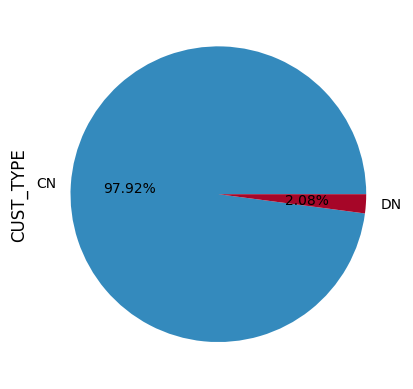

In [15]:
cust_status['CUST_TYPE'].value_counts(dropna=False).plot(kind='pie',autopct='%.2f%%')

In [16]:
df2 = cust_status.copy()

In [17]:
# Khao sat KHCN
df2_1 = df2[df2['CUST_TYPE'] =='CN']

In [18]:
df2_1['CUST_STATUS'].value_counts(dropna=False)

HOAT DONG    200929
DONG BANG    195763
NGU DONG      88097
Name: CUST_STATUS, dtype: int64

In [19]:
df2_1['CUST_STATUS'] = df2_1['CUST_STATUS'].apply(lambda x: '1. HOAT DONG' if x == 'HOAT DONG' else '2. NGU DONG' if x == 'NGU DONG' else '3. DONG BANG')

<Axes: ylabel='CUST_STATUS'>

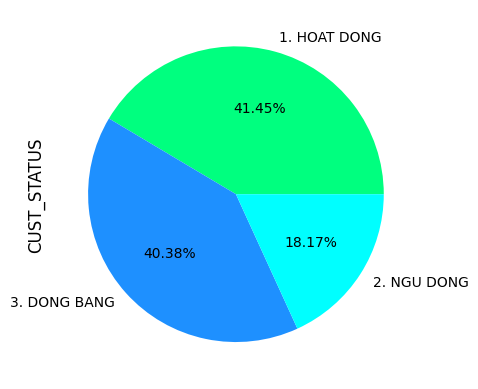

In [20]:
df2_1[['CUSTOMER_CDE', 'CUST_STATUS']].drop_duplicates()['CUST_STATUS'].value_counts().plot(kind='pie', colors=['springgreen', 'dodgerblue', 'cyan'], autopct='%.2f%%')

## DATA-PREPROCESSED

In [21]:
df3 = df2_1.merge(df1, how='inner', left_on='CUSTOMER_CDE', right_on='CUSTOMER_CDE')

In [22]:
df3.CUSTOMER_CDE.nunique()

484783

In [23]:
df3['LASTEST_TRANS_DT'].min()

Timestamp('2016-11-30 00:00:00')

In [24]:
df3['LASTEST_TRANS_DT'].notnull().sum(), df3['LASTEST_TRANS_DT'].isnull().sum()

(304024, 180765)

## LASTEST_TRANS_DT

In [25]:
tmp = df3.copy()

In [26]:
min_latest_txn = df3['LASTEST_TRANS_DT'].min()

<Axes: ylabel='LASTEST_TRANS_DT'>

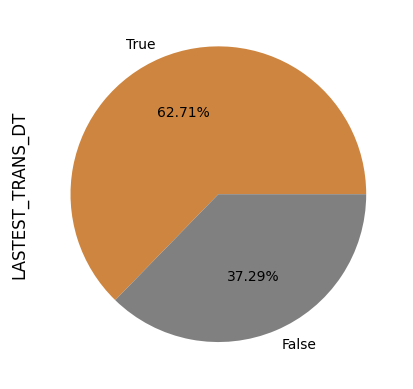

In [27]:
tmp['LASTEST_TRANS_DT'].notnull().value_counts().plot(kind='pie', autopct='%.2f%%', colors=['peru','gray'])

In [28]:
tmp['LASTEST_TRANS_DT'].fillna(min_latest_txn,inplace=True)

In [29]:
tmp = tmp[tmp['LASTEST_TRANS_DT'].notnull()]

In [30]:
tmp = tmp[['LASTEST_TRANS_DT', 'CUSTOMER_CDE', 'CUST_STATUS']].set_index('LASTEST_TRANS_DT').sort_index()

In [31]:
tmp1 = (tmp.reset_index().groupby([pd.Grouper(key='LASTEST_TRANS_DT', axis=0,freq='2M', sort=True), 'CUST_STATUS'])['CUSTOMER_CDE'].nunique() / len(tmp)).to_frame('prop').reset_index()

In [32]:
tmp1 = tmp1.sort_values(by=['LASTEST_TRANS_DT', 'CUST_STATUS'])

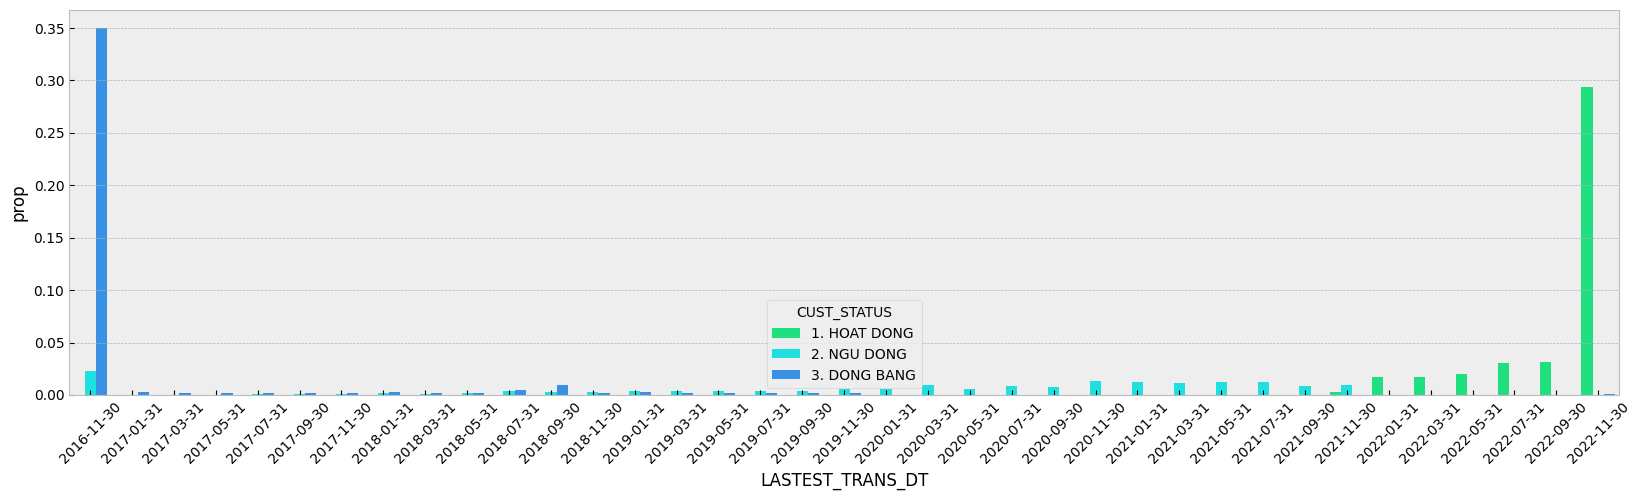

In [33]:
fig, ax = plt.subplots(1,1, figsize=(20, 5))
ax = sns.barplot(tmp1, x='LASTEST_TRANS_DT', y='prop', hue='CUST_STATUS', 
                 palette=['springgreen', 'cyan', 'dodgerblue'], 
                 hue_order=['1. HOAT DONG', '2. NGU DONG', '3. DONG BANG'],
                )
ax.tick_params(axis='x', rotation=45)
plt.show()

In [34]:
tmp2 = tmp1[(tmp1['LASTEST_TRANS_DT'] <=pd.Timestamp('2022-11-23')) & (tmp1['LASTEST_TRANS_DT'] >=pd.Timestamp('2016-12-30'))]

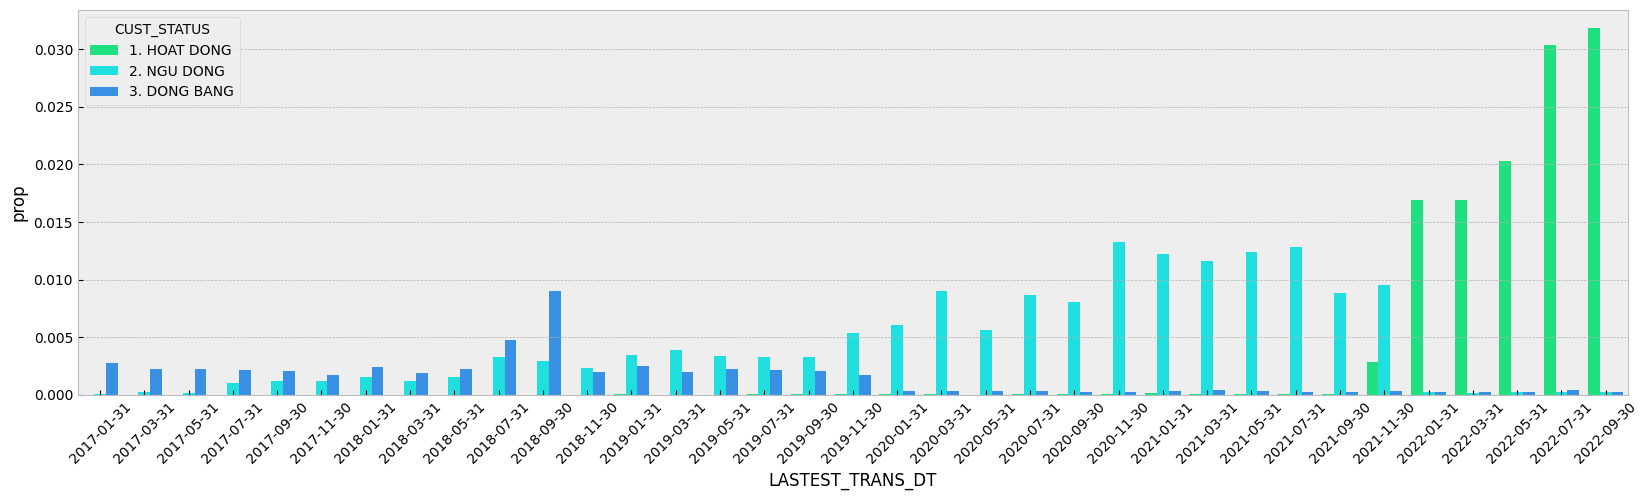

In [35]:
fig, ax = plt.subplots(1,1, figsize=(20, 5))
ax = sns.barplot(tmp2, x='LASTEST_TRANS_DT', y='prop', hue='CUST_STATUS', 
                 palette=['springgreen', 'cyan', 'dodgerblue'], 
                 hue_order=['1. HOAT DONG', '2. NGU DONG', '3. DONG BANG'],
                )
ax.tick_params(axis='x', rotation=45)
plt.show()

# DEMOGRAPHIC

## PROVINCE_NM

In [36]:
tmp = df3.copy()

In [37]:
top5_ct = tmp['PROVINCE_NM'].value_counts(dropna=False)[:5].index
# .plot(kind='pie', autopct='%.2f%%')

In [38]:
tmp['PROVINCE_NM'] = tmp['PROVINCE_NM'].apply(lambda x: 'OTHER' if x not in top5_ct else x)

<Axes: ylabel='PROVINCE_NM'>

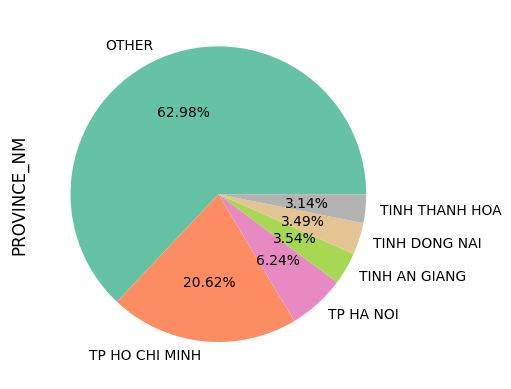

In [39]:
tmp['PROVINCE_NM'].value_counts().plot(kind='pie', autopct='%.2f%%', cmap='Set2')

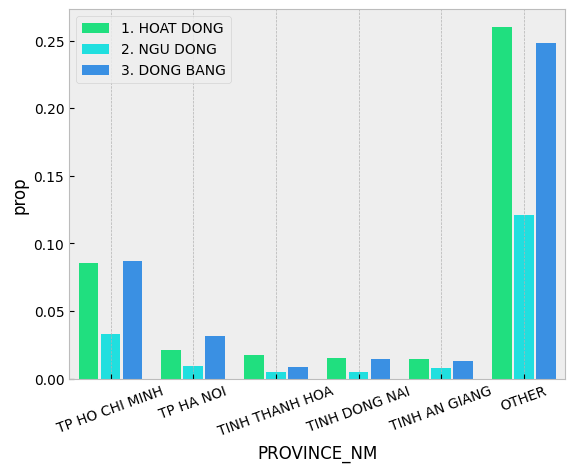

In [40]:
datap = (tmp.groupby('PROVINCE_NM')['CUST_STATUS'].value_counts(normalize=False)/len(tmp)).sort_index()[::-1].to_frame('prop').reset_index()
datap
fig,ax=plt.subplots(1,1)
sns.barplot(datap, x='PROVINCE_NM', y='prop', hue='CUST_STATUS', ax=ax, 
            hue_order=['1. HOAT DONG', '2. NGU DONG', '3. DONG BANG'], 
            palette=['springgreen', 'cyan', 'dodgerblue'], gap=0.1, fill=True)
ax.tick_params(axis='x', rotation=20)
ax.legend(loc='upper left', )
plt.grid()
plt.show()

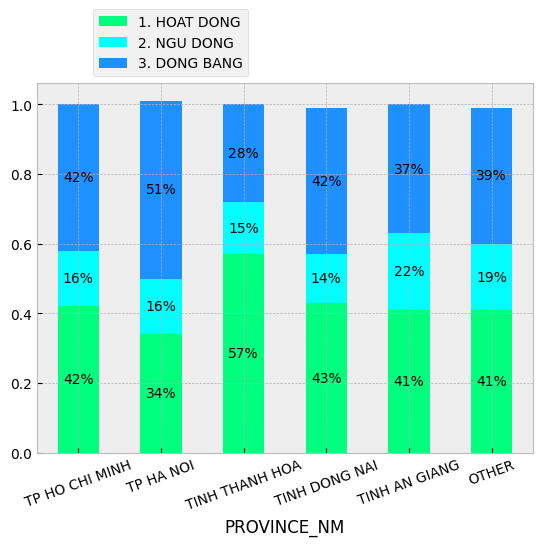

In [41]:
pct = pd.crosstab(tmp['PROVINCE_NM'], tmp['CUST_STATUS'], normalize='index').round(2)[::-1]

ax = pct.plot(kind='bar', stacked=True, color=[ 'springgreen','cyan', 'dodgerblue'],
              # index=['TP HO CHI MINH', 'TP HA NOI', 'TINH THANH HOA', 'TINH DONG NAI', 'TINH AN GIANG','OTHER']
             )
ax.tick_params(axis='x', rotation=20)
ax.legend(loc='best', 
          bbox_to_anchor=(0.1,1), 
          labels=['1. HOAT DONG', '2. NGU DONG', '3. DONG BANG'])
for c in ax.containers:
    labels = [f'{w:.0f}%' if (w:=v.get_height()*100) > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center')
plt.show()

## BIRTHDAY

In [42]:
tmp = df3.copy()

In [43]:
col = 'BIRTHDAY'

In [44]:
tmp['BIRTHDAY'].isna().sum()

0

In [45]:
tmp[col] = pd.to_datetime(tmp[col], errors='coerce')
tmp[col] = tmp[col].astype('datetime64[D]')

In [46]:
tmp[tmp[col] <= '1923-01-01'].shape[0], tmp[tmp[col] <= '1923-01-01'].shape[0] / len(tmp) * 100

(98, 0.02021498012537413)

In [47]:
tmp['BIRTHDAY'].min(), tmp['BIRTHDAY'].max(), 

(Timestamp('1678-11-20 00:00:00'), Timestamp('2022-08-02 00:00:00'))

In [48]:
tmp = tmp[tmp[col] > '1923-01-01']
tmp1 = tmp.set_index('BIRTHDAY')
# tmp1

In [49]:
tmp1.index.min(), tmp1.index.max()

(Timestamp('1923-03-05 00:00:00'), Timestamp('2022-08-02 00:00:00'))

In [50]:
data = tmp1.resample('5Y')['CUSTOMER_CDE'].nunique().to_frame('count').reset_index()
data['pct'] = data['count']/data['count'].sum()

<Axes: xlabel='BIRTHDAY'>

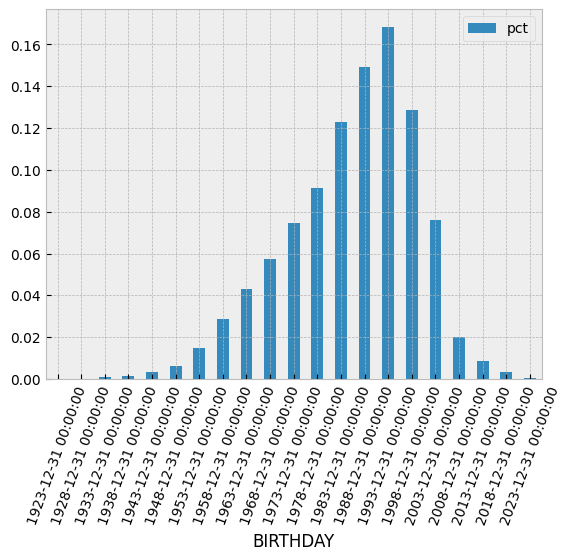

In [51]:
data[['BIRTHDAY', 'pct']].set_index('BIRTHDAY').plot(kind='bar', rot=70)

In [52]:
tmp2 = data[['BIRTHDAY', 'pct']].set_index('BIRTHDAY')
tmp2[(tmp2.index >= '1968-01-01') & (tmp2.index < '1998-01-01')]['pct'].sum()

0.6636350506530215

In [78]:
data = tmp1.resample('1Y')['CUST_STATUS'].value_counts(normalize=False) 
data = data.to_frame('count').reset_index()
data['density'] = data['count']/data['count'].sum()

<Axes: xlabel='BIRTHDAY', ylabel='density'>

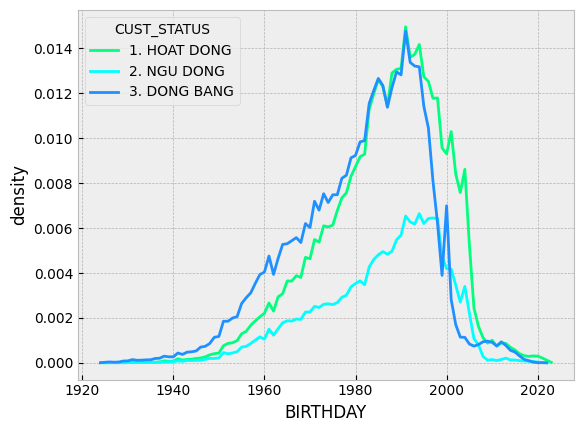

In [79]:
sns.lineplot(data,x='BIRTHDAY',y='density',hue='CUST_STATUS', palette=['springgreen','cyan', 'dodgerblue', ], hue_order=['1. HOAT DONG','2. NGU DONG', '3. DONG BANG'])

In [56]:
groupby_col = 'BIRTHDAY'

In [57]:
# data = tmp1.groupby(groupby_col)['CUST_STATUS'].value_counts()
data = tmp1.resample('5Y')['CUST_STATUS'].value_counts(normalize=False) 
# data

In [58]:
data = data.to_frame('count').reset_index()

In [59]:
res = data.pivot_table(index=groupby_col, columns='CUST_STATUS', values='count',fill_value=0)

In [60]:
res = res.apply(lambda x: x/x.sum(), axis=1)

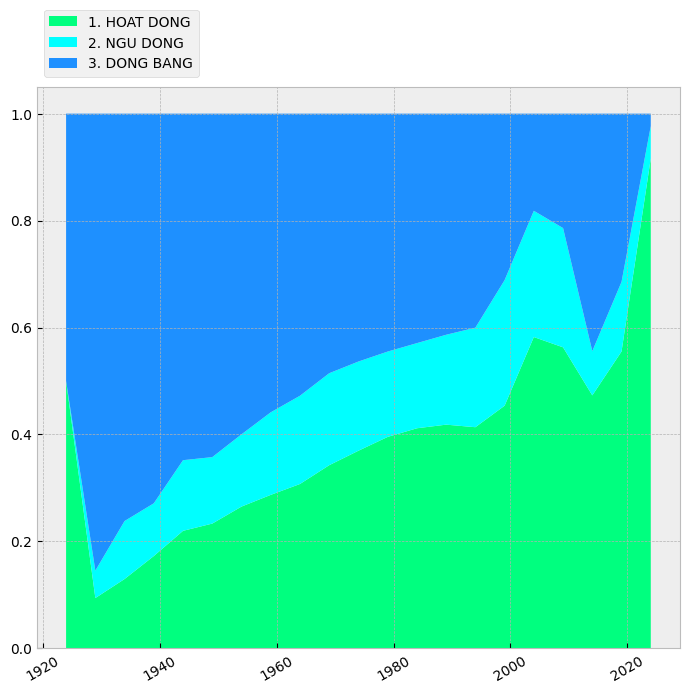

In [61]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
ax.stackplot(res.index.tolist(), res.values.T, labels=res.columns.tolist(), colors=[ 'springgreen','cyan', 'dodgerblue'])
ax.tick_params(axis='x', rotation=30)
ax.legend(loc='upper left', bbox_to_anchor=(0,1.15))
plt.tight_layout()
plt.show()

## AGE & GEN

In [62]:
def bin_age_group(x):
    if x < 18:
        return '1. Under 18'
    elif x < 22:
        return '2. From 18 to 22'
    elif x < 25:
        return '3. From 22 to 25'
    elif x < 30:
        return '4. From 25 to 30'
    elif x < 35:
        return '5. From 30 to 35'
    elif x < 45:
        return '6. From 35 to 45'
    elif x < 65:
        return '7. From 45 to 65'
    else:
        return '8. Over 65'

In [63]:
def bin_gen_group(x):
    if x < pd.Timestamp('1965-01-01'):
        return '5. Before Gen X'
    elif x < pd.Timestamp('1981-01-01'):
        return '4. Gen X'
    elif x < pd.Timestamp('1997-01-01'):
        return '3. Gen Y'
    elif x < pd.Timestamp('2012-01-01'):
        return '2. Gen Z'
    else:
        return '1. Gen A'

In [64]:
tmp = df3.copy()

In [65]:
tmp[col] = pd.to_datetime(tmp[col], errors='coerce')
tmp[col] = tmp[col].astype('datetime64[D]')

In [66]:
tmp = tmp[tmp[col] > '1923-01-01']
# tmp1 = tmp.set_index('BIRTHDAY')
# tmp1

In [67]:
age = ((datetime(2024,1,1) - tmp['BIRTHDAY']) / pd.Timedelta('365.25 days'))

In [80]:
tmp['AGE'] = age
tmp['AGE_GROUP'] = age.apply(lambda x:bin_age_group(x))
tmp['GEN_GROUP'] = tmp['BIRTHDAY'].apply(lambda x:bin_gen_group(x))

<Axes: xlabel='AGE', ylabel='Density'>

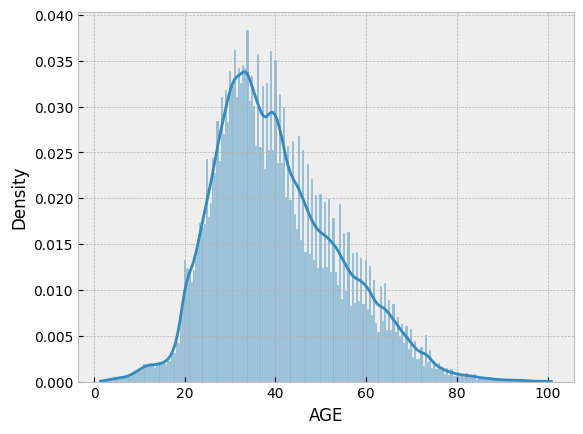

In [81]:
sns.histplot(tmp['AGE'], kde=True,stat='density', common_norm=False)

<Axes: xlabel='AGE', ylabel='Density'>

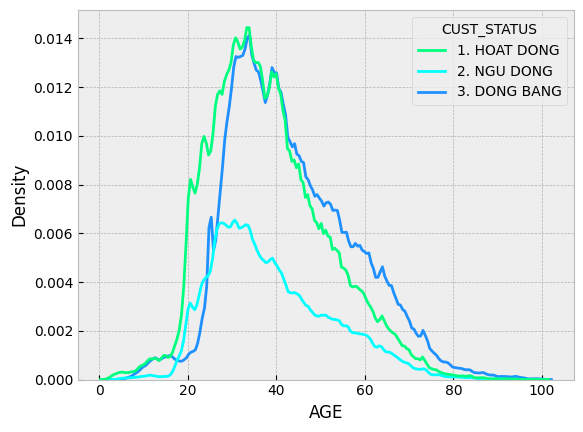

In [89]:
sns.kdeplot(tmp,x='AGE', hue='CUST_STATUS', palette=['springgreen','cyan', 'dodgerblue', ], hue_order=['1. HOAT DONG','2. NGU DONG', '3. DONG BANG'], bw_adjust=.35)

### AGE GROUP

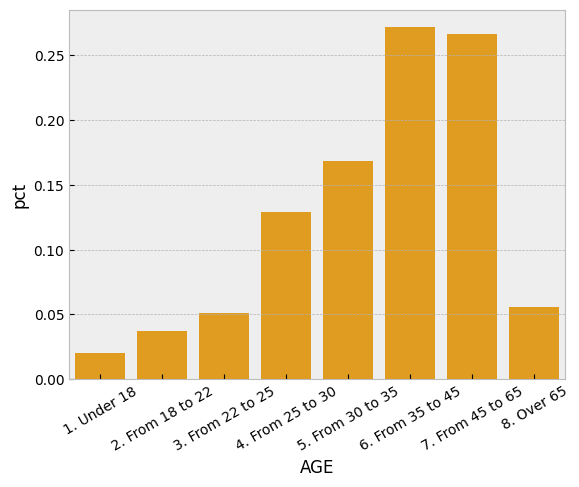

In [69]:
tmp1 = tmp['AGE_GROUP'].value_counts(normalize=True).sort_index().reset_index()
tmp1.columns = ['AGE', 'pct']
ax = sns.barplot(tmp1, x='AGE', y='pct', color='orange')
ax.tick_params(axis='x', rotation=30)
# ax.legend(loc='upper left', bbox_to_anchor=(1,1), labels=[''])

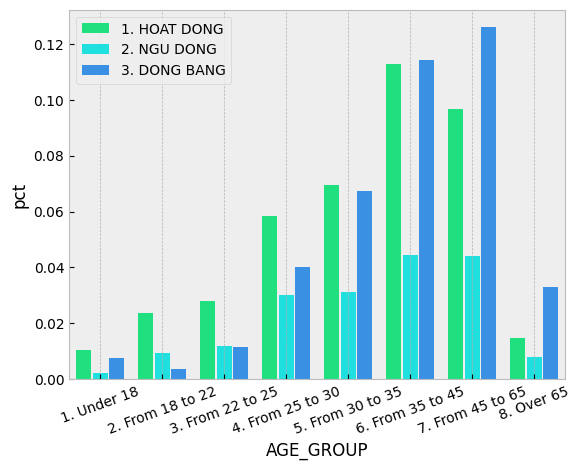

In [70]:
datap = (tmp.groupby('AGE_GROUP')['CUST_STATUS'].value_counts(normalize=False)/len(tmp)).sort_index().to_frame('pct').reset_index()
datap
fig,ax=plt.subplots(1,1)
sns.barplot(datap, x='AGE_GROUP', y='pct', hue='CUST_STATUS', ax=ax, 
            hue_order=['1. HOAT DONG', '2. NGU DONG', '3. DONG BANG'], 
            palette=['springgreen', 'cyan', 'dodgerblue'], gap=0.1, fill=True)
ax.tick_params(axis='x', rotation=20)
ax.legend(loc='upper left', )
plt.grid()
plt.show()

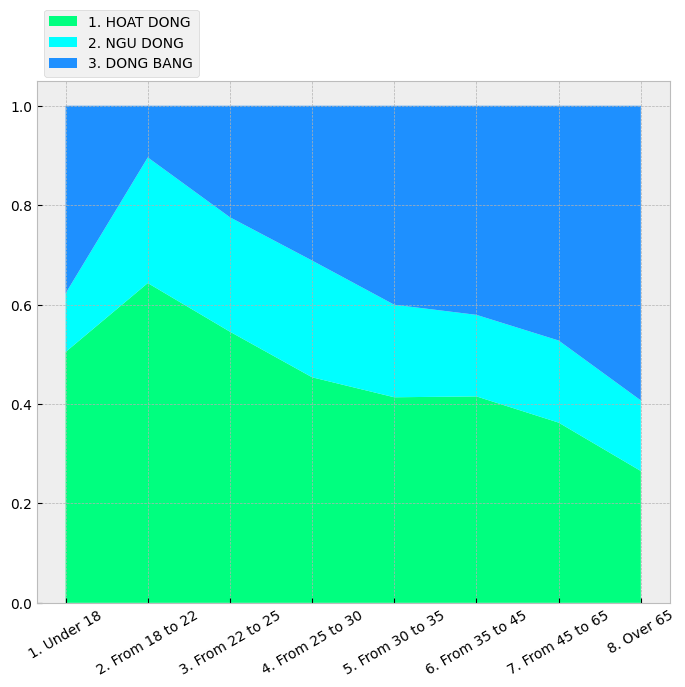

In [71]:
data = tmp[:]

data = data.groupby('AGE_GROUP')['CUST_STATUS'].value_counts()
data = data.to_frame('count').reset_index()

res = data.pivot_table(index='AGE_GROUP', columns='CUST_STATUS', values='count',fill_value=0)

res = res.apply(lambda x: x/x.sum(), axis=1)

fig, ax = plt.subplots(1,1, figsize=(7,7))
ax.stackplot(res.index.tolist(), res.values.T, labels=res.columns.tolist(), colors=['springgreen', 'cyan', 'dodgerblue'])
ax.tick_params(axis='x', rotation=30)
ax.legend(loc='upper left', bbox_to_anchor=(0,1.15))
plt.tight_layout()
plt.show()

### GEN

<Axes: xlabel='GEN', ylabel='count'>

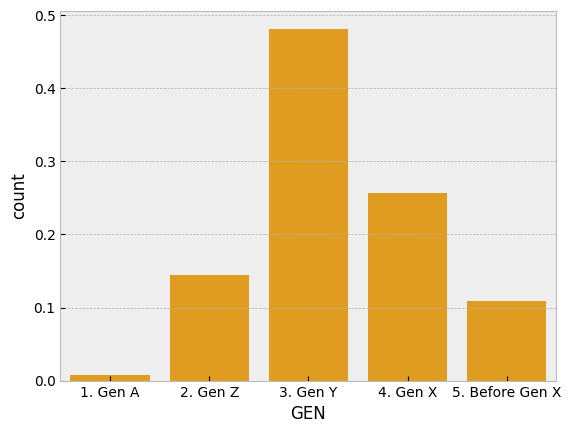

In [72]:
tmp1 = tmp['GEN_GROUP'].value_counts(normalize=True).sort_index().reset_index()
tmp1.columns = ['GEN', 'count']
sns.barplot(tmp1, x='GEN', y='count', color='orange')

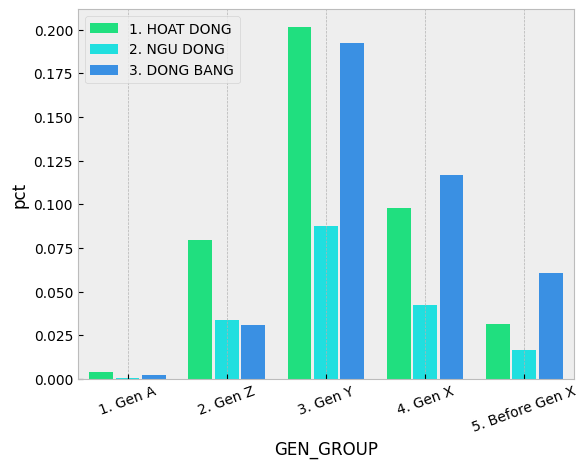

In [73]:
datap = (tmp.groupby('GEN_GROUP')['CUST_STATUS'].value_counts(normalize=False)/len(tmp)).sort_index().to_frame('pct').reset_index()
datap
fig,ax=plt.subplots(1,1)
sns.barplot(datap, x='GEN_GROUP', y='pct', hue='CUST_STATUS', ax=ax, 
            hue_order=['1. HOAT DONG', '2. NGU DONG', '3. DONG BANG'], 
            palette=['springgreen', 'cyan', 'dodgerblue'], gap=0.1, fill=True)
ax.tick_params(axis='x', rotation=20)
ax.legend(loc='upper left', )
plt.grid()
plt.show()

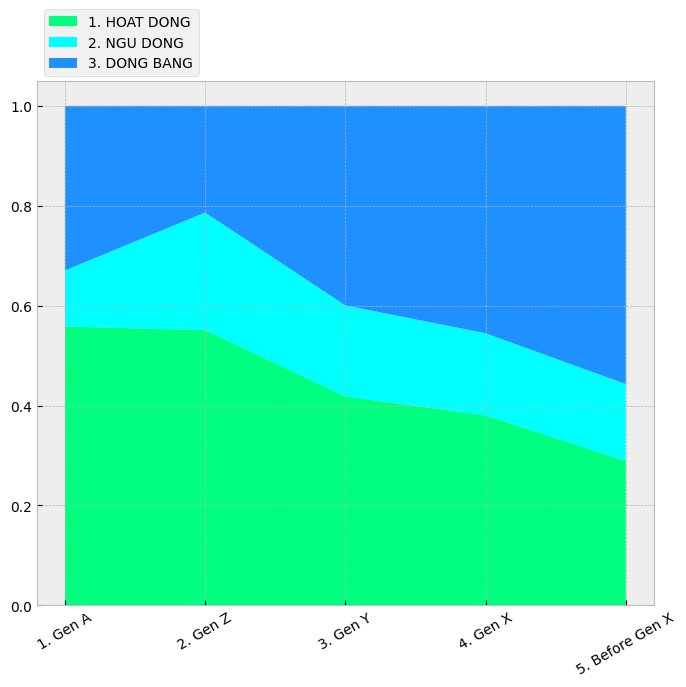

In [74]:
data = tmp[:]

data = data.groupby('GEN_GROUP')['CUST_STATUS'].value_counts()
data = data.to_frame('count').reset_index()

res = data.pivot_table(index='GEN_GROUP', columns='CUST_STATUS', values='count',fill_value=0)

res = res.apply(lambda x: x/x.sum(), axis=1)

fig, ax = plt.subplots(1,1, figsize=(7,7))
ax.stackplot(res.index.tolist(), res.values.T, labels=res.columns.tolist(), colors=['springgreen', 'cyan', 'dodgerblue'])
ax.tick_params(axis='x', rotation=30)
ax.legend(loc='upper left', bbox_to_anchor=(0,1.15))
plt.tight_layout()
plt.show()

In [75]:
data = tmp[:]

In [76]:
groupby_col = 'GEN_GROUP'

In [77]:
data = data.groupby(groupby_col)['CUST_STATUS'].value_counts()
data = data.to_frame('count').reset_index()

In [78]:
res = data.pivot_table(index=groupby_col, columns='CUST_STATUS', values='count',fill_value=0)

In [79]:
res = res.apply(lambda x: x/x.sum(), axis=1)

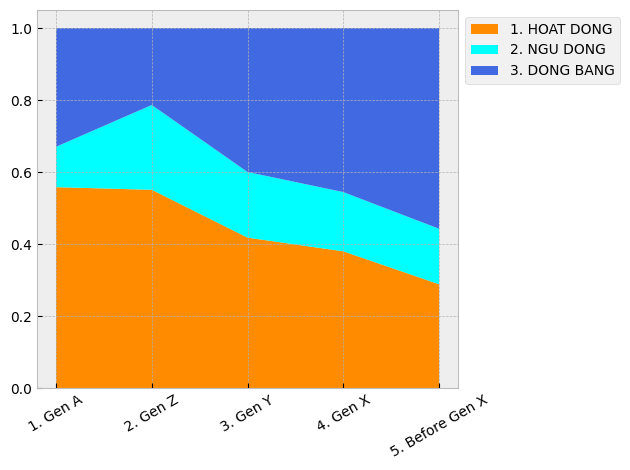

In [80]:
fig, ax = plt.subplots(1,1)
ax.stackplot(res.index.tolist(), res.values.T, labels=res.columns.tolist(), colors=['darkorange', 'aqua', 'royalblue'])
ax.tick_params(axis='x', rotation=30)
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

## GENDER

In [81]:
tmp = df3.copy()

In [82]:
tmp['GENDER_CDE'].unique()

array(['FEMALE', 'MALE', ' ', 'F', 'M'], dtype=object)

In [83]:
def clean_gender(x):
    if x == 'M':
        return 'MALE'
    elif x == 'F':
        return 'FEMALE'
    elif x.strip() == '':
        return 'N/A'
    return x

In [84]:
tmp['GENDER_CDE'] = tmp['GENDER_CDE'].apply(lambda x: clean_gender(x))

<Axes: ylabel='GENDER_CDE'>

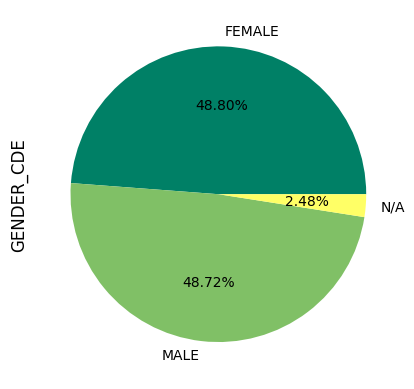

In [85]:
tmp['GENDER_CDE'].value_counts().plot(kind='pie', autopct='%.2f%%', cmap='summer')

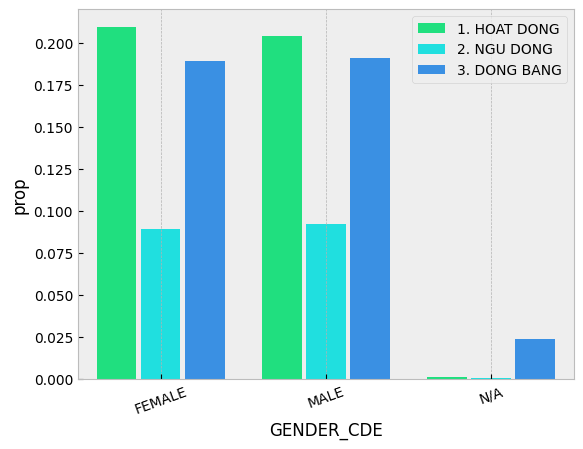

In [86]:
datap = (tmp.groupby('GENDER_CDE')['CUST_STATUS'].value_counts(normalize=False)/len(tmp)).sort_index().to_frame('prop').reset_index()
datap
fig,ax=plt.subplots(1,1)
sns.barplot(datap, x='GENDER_CDE', y='prop', hue='CUST_STATUS', ax=ax, 
            hue_order=['1. HOAT DONG', '2. NGU DONG', '3. DONG BANG'], 
            palette=['springgreen', 'cyan', 'dodgerblue'], gap=0.1, fill=True)
ax.tick_params(axis='x', rotation=20)
ax.legend(loc='best', )
plt.grid()
plt.show()

In [87]:
df3.columns

Index(['PROCESS_DT', 'CUSTOMER_CDE', 'CUST_TYPE', 'CUST_STATUS', 'BH', 'IB',
       'MB', 'PAY', 'TKTT', 'TK', 'VAY', 'DEBIT', 'MD', 'LC', 'FX', 'TTQT',
       'SP_KHAC', 'SD_BH', 'SD_IB', 'SD_MB', 'SD_PAY', 'SD_TKTT', 'SD_TK',
       'SD_VAY', 'SD_MD', 'SD_LC', 'SD_FX', 'SD_TTQT', 'CREDIT', 'PREPAID',
       'SD_CREDIT', 'SD_PREPAID', 'PAYROLL', 'SD_PAYROLL', 'SD_SP_KHAC',
       'OS_AMT_LCL', 'ACTUAL_AMT_LCL', 'LASTEST_TRANS_DT', 'REC_CREATE_DT',
       'CUST_OPEN_DT', 'RATE_LEVEL_NAME', 'BIRTHDAY', 'MATRIMONY_STATUS',
       'GENDER_CDE', 'PROVINCE_NM', 'CUS_OPEN_DT', 'DB_GRP_CIC'],
      dtype='object')

## MATRIMONY

In [88]:
tmp = df3.copy()

In [89]:
tmp['MATRIMONY_STATUS'].unique()

array(['MARRIED', ' ', 'SINGLE', 'OTHER', 'DIVORCED', 'S', None, 'M',
       'PARTNER', 'D', 'W', 'WIDOWED'], dtype=object)

In [90]:
tmp['MATRIMONY_STATUS'].value_counts(dropna=False)

            225046
MARRIED     175965
SINGLE       83241
OTHER          407
DIVORCED        51
None            24
S               23
PARTNER         21
M                7
W                2
D                1
WIDOWED          1
Name: MATRIMONY_STATUS, dtype: int64

In [91]:
def clean_matrimony(x):
    if x == 'S':
        return 'SINGLE'
    elif x == 'M':
        return 'MARRIED'
    elif (type(x) == str) and (x.strip() == ''):
        return 'N/A'
    elif x is None:
        return 'N/A'
    elif (x == 'W') or (x=='WIDOWED') or (x=='PARTNER'):
        return 'OTHER'
    elif (x == 'D') or (x == 'DIVORCED'):
        return 'OTHER'
    return x

In [92]:
tmp['MATRIMONY_STATUS'] = tmp['MATRIMONY_STATUS'].apply(lambda x: clean_matrimony(x))

In [93]:
tmp['MATRIMONY_STATUS'].value_counts(dropna=False)

N/A        225070
MARRIED    175972
SINGLE      83264
OTHER         483
Name: MATRIMONY_STATUS, dtype: int64

<Axes: ylabel='MATRIMONY_STATUS'>

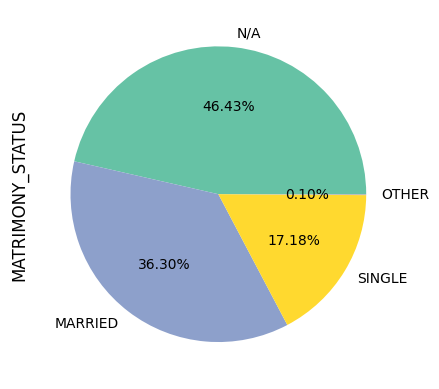

In [94]:
tmp['MATRIMONY_STATUS'].value_counts().plot(kind='pie', autopct='%.2f%%', cmap='Set2')

In [95]:
datap = (tmp.groupby('MATRIMONY_STATUS')['CUST_STATUS'].value_counts(normalize=False)/len(tmp)).sort_index()[::-1].to_frame('prop').reset_index()
# datap

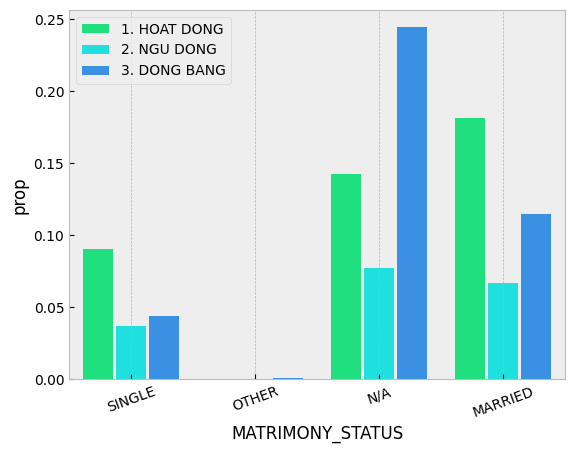

In [96]:
fig,ax=plt.subplots(1,1)
sns.barplot(datap, x='MATRIMONY_STATUS', y='prop', hue='CUST_STATUS', ax=ax, 
            hue_order=['1. HOAT DONG', '2. NGU DONG', '3. DONG BANG'], 
            palette=['springgreen', 'cyan', 'dodgerblue'], gap=0.1, fill=True)
ax.tick_params(axis='x', rotation=20)
ax.legend(loc='best', )
plt.grid()
plt.show()

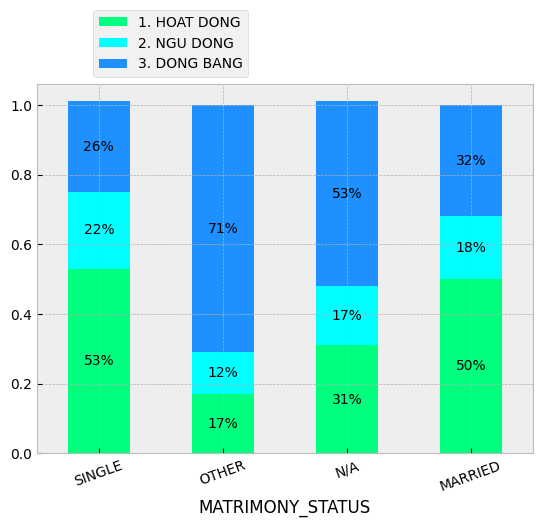

In [97]:
pct = pd.crosstab(tmp['MATRIMONY_STATUS'], tmp['CUST_STATUS'], normalize='index').round(2)[::-1]

ax = pct.plot(kind='bar', stacked=True, color=[ 'springgreen','cyan', 'dodgerblue'],
              # index=['TP HO CHI MINH', 'TP HA NOI', 'TINH THANH HOA', 'TINH DONG NAI', 'TINH AN GIANG','OTHER']
             )
ax.tick_params(axis='x', rotation=20)
ax.legend(loc='best', 
          bbox_to_anchor=(0.1,1), 
          labels=['1. HOAT DONG', '2. NGU DONG', '3. DONG BANG'])
for c in ax.containers:
    labels = [f'{w:.0f}%' if (w:=v.get_height()*100) > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center')
plt.show()

# RELATIONSHIP WITH BANK

## RATE_LEVEL_NAME

In [98]:
tmp = df3.copy()

<Axes: >

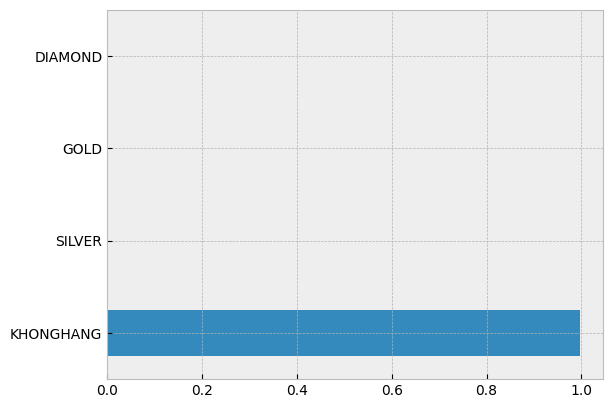

In [99]:
(tmp['RATE_LEVEL_NAME'].apply(lambda x:x.upper()).value_counts(normalize=True)).plot(kind='barh')

## CUS_OPEN_DT

In [100]:
df3 = df2_1.merge(df1, how='inner', left_on='CUSTOMER_CDE', right_on='CUSTOMER_CDE')

In [101]:
tmp = df3.copy()

In [102]:
col = 'CUS_OPEN_DT'

In [103]:
tmp[col] = pd.to_datetime(tmp[col], errors='coerce')
tmp[col] = tmp[col].astype('datetime64[D]')

In [104]:
tmp['CUS_OPEN_DT'].isna().sum()

64

In [105]:
tmp[col] = pd.to_datetime(tmp[col], errors='coerce')
tmp[col] = tmp[col].astype('datetime64[D]')

In [106]:
# tmp[tmp[col] <= '1923-01-01'].shape[0], tmp[tmp[col] <= '1923-01-01'].shape[0] / len(tmp) * 100

In [107]:
tmp['CUS_OPEN_DT'].min(), tmp['CUS_OPEN_DT'].max(), 

(Timestamp('2009-06-04 00:00:00'), Timestamp('2022-11-18 23:46:00'))

<Axes: xlabel='CUS_OPEN_DT'>

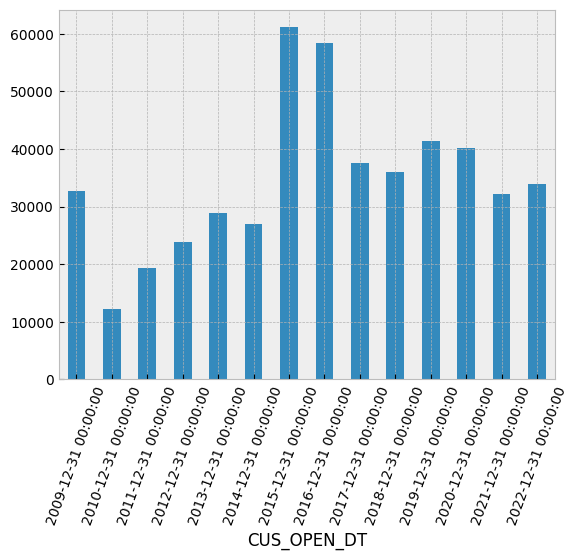

In [108]:
tmp.set_index(col)['CUSTOMER_CDE'].resample('1Y').nunique().plot(kind='bar', rot=70)

In [109]:
tmp = df3.copy()

In [110]:
tmp['CUS_OPEN_DT'].isna().sum()

64

In [111]:
tmp = tmp[~tmp['CUS_OPEN_DT'].isna()]

In [112]:
tmp['CUS_OPEN_DT'].isna().sum()

0

In [113]:
tmp['CUS_OPEN_DT'].min(), tmp['CUS_OPEN_DT'].max(), 

(Timestamp('2009-06-04 00:00:00'), Timestamp('2022-11-18 23:46:00'))

In [114]:
tmp[col] = pd.to_datetime(tmp[col], errors='coerce')
tmp[col] = tmp[col].astype('datetime64[D]')

In [115]:
rel = ((datetime(2024,1,1) - tmp['CUS_OPEN_DT']) / pd.Timedelta('365.25 days'))

Text(0.5, 1.0, 'Relationship Year')

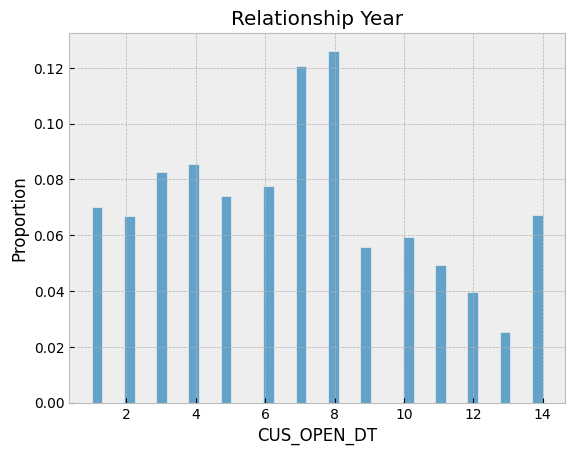

In [116]:
sns.histplot(rel.apply(int), bins=42,stat='proportion')
plt.title('Relationship Year')

### REL YEAR & AGE

In [117]:
tmp = df3.copy()

In [118]:
tmp = tmp[~tmp['CUS_OPEN_DT'].isna()]

In [119]:
tmp['CUS_OPEN_DT'].min(), tmp['CUS_OPEN_DT'].max(), 

(Timestamp('2009-06-04 00:00:00'), Timestamp('2022-11-18 23:46:00'))

In [120]:
tmp = tmp[['CUST_STATUS', 'BIRTHDAY', 'CUST_OPEN_DT']]
tmp = tmp[tmp['BIRTHDAY']>=pd.Timestamp('1924-01-01')]
tmp['BIRTHDAY'] = pd.to_datetime(tmp['BIRTHDAY'], errors='coerce').astype('datetime64[D]')
tmp['CUST_OPEN_DT'] = pd.to_datetime(tmp['CUST_OPEN_DT'], errors='coerce').astype('datetime64[D]')
tmp['AGE'] = ((datetime(2024,1,1) - tmp['BIRTHDAY']) / pd.Timedelta('365.25 days'))
tmp['REL_YEAR'] = ((datetime(2024,1,1) - tmp['CUST_OPEN_DT']) / pd.Timedelta('365.25 days'))
tmp = tmp[tmp['REL_YEAR']<=14]
tmp = tmp[tmp['AGE']<80]
tmp = tmp.sample(frac=0.5)
tmp = tmp.sort_values(by='CUST_STATUS')
len(tmp)

224948

In [121]:
# This take long

In [122]:
# g = sns.jointplot(tmp, x='AGE', y='REL_YEAR', hue='CUST_STATUS', kind='kde',levels=100, linewidths=1, palette=[ 'springgreen','cyan', 'dodgerblue'], 
#                   fill=True, alpha=0.5, legend=False,)
# sns.kdeplot(tmp, x='AGE', y='REL_YEAR', levels=4,linewidths=1.5, color='orange', legend=False, ax=g.ax_joint)

In [123]:
# This take long

In [124]:
# sns.displot(tmp, x='AGE', y='REL_YEAR', kind='kde', col='CUST_STATUS',levels=10,fill=True,hue='CUST_STATUS',palette=[ 'springgreen','cyan', 'dodgerblue'])

In [125]:
# Additional Charts

In [126]:
# fig, ax = plt.subplots(1,1, figsize=(7,7))
# sns.scatterplot(tmp, x='AGE', y='REL_YEAR',hue='CUST_STATUS', s=1,palette=[ 'springgreen','cyan', 'dodgerblue'],ax=ax)
# # sns.histplot(tmp, x='AGE', y='REL_YEAR',hue='CUST_STATUS', bins=50, pthresh=.05,palette=[ 'springgreen','cyan', 'dodgerblue'],ax=ax, alpha=0.85)
# sns.kdeplot(tmp, x='AGE', y='REL_YEAR',hue='CUST_STATUS',levels=3, linewidths=1,palette=[ 'springgreen','cyan', 'dodgerblue'],ax=ax)
# sns.kdeplot(tmp, x='AGE', y='REL_YEAR',levels=3, linewidths=1.5,color='orange',ax=ax, )
# # ax.grid(False)
# plt.show()

In [127]:
# fig, ax = plt.subplots(1,1, figsize=(7,7))
# sns.kdeplot(tmp, x='AGE', y='REL_YEAR',hue='CUST_STATUS',palette=[ 'springgreen','cyan', 'dodgerblue'],ax=ax, fill=True, alpha=0.5)
# plt.show()

### REL_GROUP

In [128]:
tmp = df3.copy()

In [129]:
def bin_rel_group(x):
    if x < 1:
        return '1. Less 1 year'
    elif x < 3:
        return '2. From 1 to 3 year'
    elif x < 5:
        return '3. From 3 to 5 year'
    elif x < 10:
        return '4. From 5 to 10 year'
    else:
        return '5. Over 10 year'

In [130]:
tmp['REL_GROUP'] = rel.apply(lambda x: bin_rel_group(x))

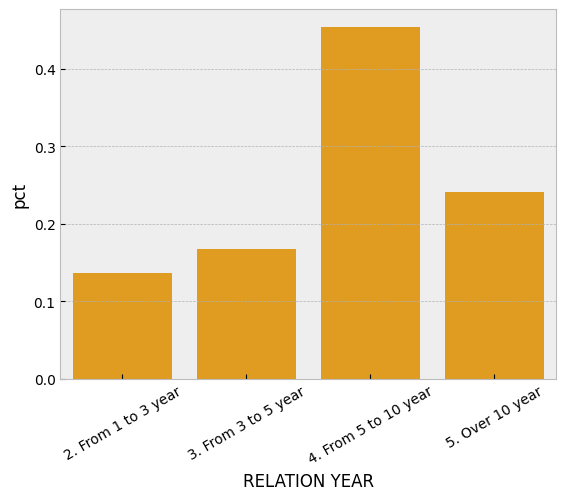

In [131]:
tmp1 = tmp['REL_GROUP'].value_counts(normalize=True).sort_index().reset_index()
tmp1.columns = ['RELATION YEAR', 'pct']
ax = sns.barplot(tmp1, x='RELATION YEAR', y='pct', color='orange')
ax.tick_params(axis='x', rotation=30)
# ax.legend(loc='upper left', bbox_to_anchor=(1,1), labels=[''])

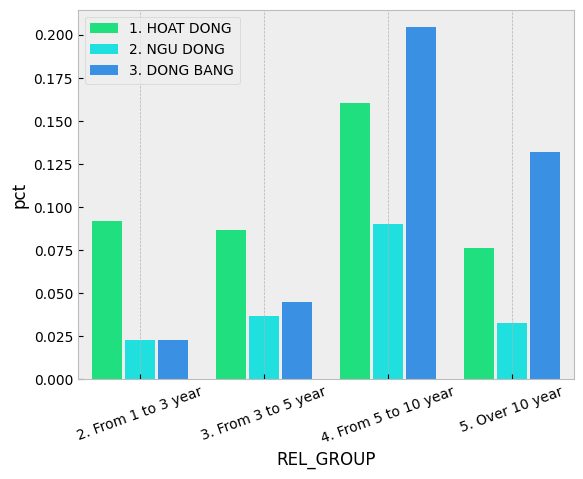

In [132]:
datap = (tmp.groupby('REL_GROUP')['CUST_STATUS'].value_counts(normalize=False)/len(tmp)).sort_index().to_frame('pct').reset_index()
datap
fig,ax=plt.subplots(1,1)
sns.barplot(datap, x='REL_GROUP', y='pct', hue='CUST_STATUS', ax=ax, 
            hue_order=['1. HOAT DONG', '2. NGU DONG', '3. DONG BANG'], 
            palette=['springgreen', 'cyan', 'dodgerblue'], gap=0.1, fill=True)
ax.tick_params(axis='x', rotation=20)
ax.legend(loc='upper left', )
plt.grid()
plt.show()

In [133]:
data = tmp
data = data.groupby('REL_GROUP')['CUST_STATUS'].value_counts()
data = data.to_frame('count').reset_index()
res = data.pivot_table(index='REL_GROUP', columns='CUST_STATUS', values='count',fill_value=0)
res = res.apply(lambda x: x/x.sum(), axis=1)

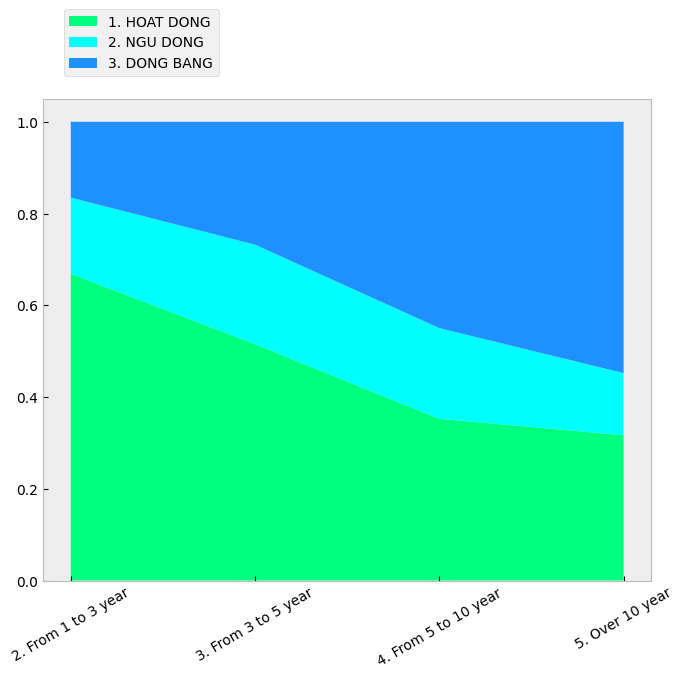

In [134]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
ax.stackplot(res.index.tolist(), res.values.T, labels=res.columns.tolist(), colors=['springgreen','cyan', 'dodgerblue'])
ax.tick_params(axis='x', rotation=30)
ax.legend(loc='best', bbox_to_anchor=(0.3,1.2))
ax.grid()
plt.tight_layout()
plt.show()

# FINANCE

In [135]:
df4 = df3.merge(credit_data, how='left', left_on='CUSTOMER_CDE', right_on='CUSTOMER_CDE')

In [136]:
df4.columns

Index(['PROCESS_DT', 'CUSTOMER_CDE', 'CUST_TYPE', 'CUST_STATUS', 'BH', 'IB',
       'MB', 'PAY', 'TKTT', 'TK', 'VAY', 'DEBIT', 'MD', 'LC', 'FX', 'TTQT',
       'SP_KHAC', 'SD_BH', 'SD_IB', 'SD_MB', 'SD_PAY', 'SD_TKTT', 'SD_TK',
       'SD_VAY', 'SD_MD', 'SD_LC', 'SD_FX', 'SD_TTQT', 'CREDIT', 'PREPAID',
       'SD_CREDIT', 'SD_PREPAID', 'PAYROLL', 'SD_PAYROLL', 'SD_SP_KHAC',
       'OS_AMT_LCL', 'ACTUAL_AMT_LCL', 'LASTEST_TRANS_DT', 'REC_CREATE_DT',
       'CUST_OPEN_DT', 'RATE_LEVEL_NAME', 'BIRTHDAY', 'MATRIMONY_STATUS',
       'GENDER_CDE', 'PROVINCE_NM', 'CUS_OPEN_DT', 'DB_GRP_CIC',
       'CREDIT_SCORE'],
      dtype='object')

## DEBIT_GROUP

In [137]:
tmp = df4.copy()

In [138]:
tmp['DB_GRP_CIC'].value_counts(dropna=False, normalize=True)

None      0.999045
NHOM 2    0.000526
NHOM 4    0.000167
NHOM 3    0.000142
NHOM 5    0.000120
Name: DB_GRP_CIC, dtype: float64

In [139]:
463/len(tmp) * 100

0.09550546732702268

<Axes: ylabel='DB_GRP_CIC'>

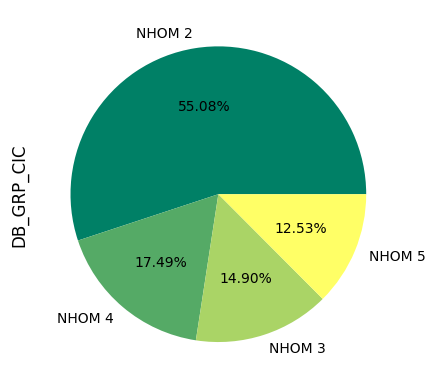

In [140]:
tmp[~tmp['DB_GRP_CIC'].isnull()]['DB_GRP_CIC'].value_counts(normalize=True).plot(kind='pie', autopct='%.2f%%', cmap='summer')

## CREDIT SCORE

In [141]:
tmp = df4.copy()

In [142]:
tmp['CREDIT_SCORE'].isna().sum(), tmp['CREDIT_SCORE'].isna().sum()/len(tmp) * 100

(476030, 98.19323458246784)

In [143]:
(~tmp['CREDIT_SCORE'].isna()).sum(), (~tmp['CREDIT_SCORE'].isna()).sum()/len(tmp) * 100

(8759, 1.8067654175321635)

<Axes: xlabel='CREDIT_SCORE', ylabel='Proportion'>

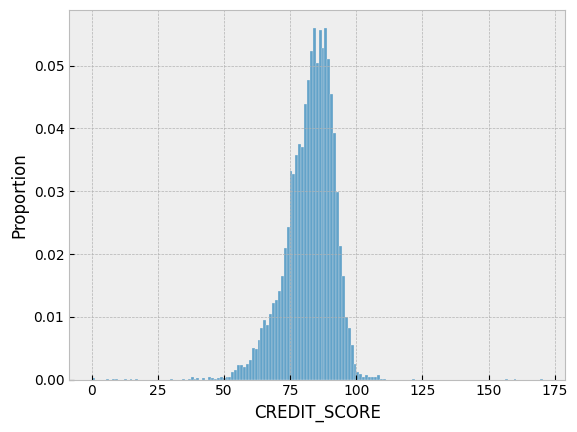

In [144]:
sns.histplot(tmp['CREDIT_SCORE'], stat='proportion')

In [145]:
tmp1 = tmp[['DB_GRP_CIC', 'CREDIT_SCORE', 'CUST_STATUS']]
tmp1 = tmp1[tmp1['CREDIT_SCORE'].notnull()]
tmp1['DB_GRP_CIC'].fillna('N/A',inplace=True)

In [146]:
tmp1 = tmp1.sort_values(by=['CUST_STATUS', 'CREDIT_SCORE'])

In [147]:
pal = sns.color_palette("flare")

In [148]:
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight='bold', color=color,ha='left', va='center', transform=ax.transAxes)

In [149]:
sns.set_theme(style='white', rc={'axes.facecolor': (0,0,0,0)})

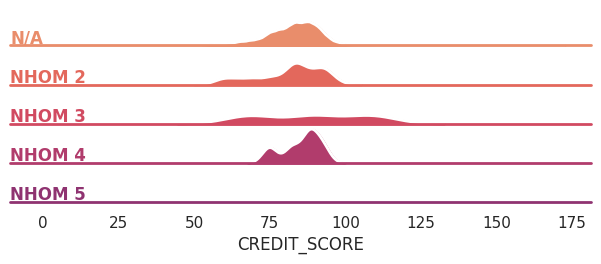

In [150]:
g = sns.FacetGrid(tmp1, row='DB_GRP_CIC', hue='DB_GRP_CIC', aspect=15, height=0.5, palette=pal)
g.map(sns.kdeplot,'CREDIT_SCORE', bw_adjust=.5, clip_on=False, fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot,'CREDIT_SCORE',clip_on=False,color='w', lw=2,bw_adjust=0.5)
g.refline(y=0, linewidth=2, linestyle='-',color=None, clip_on=False)
g.map(label,'CREDIT_SCORE')
g.figure.subplots_adjust(hspace=0.1)
g.set_titles("")
g.set(yticks=[],ylabel="")
g.despine(bottom=True, left=True)

# BANK PRODUCTS

In [151]:
# sns.reset_defaults()
plt.style.use('bmh')

## TKTT

In [90]:
tmp = df2_1.copy()

In [91]:
tmp['CUSTOMER_CDE'].nunique()

484783

In [92]:
tmp['PROCESS_DT'].unique()

array(['2022-11-18T00:00:00.000000000'], dtype='datetime64[ns]')

In [93]:
tmp['SD_TKTT'] = tmp['SD_TKTT'].fillna(0)

In [94]:
tmp['TKTT'] = tmp['TKTT'].fillna(0)

<Axes: ylabel='SD_TKTT'>

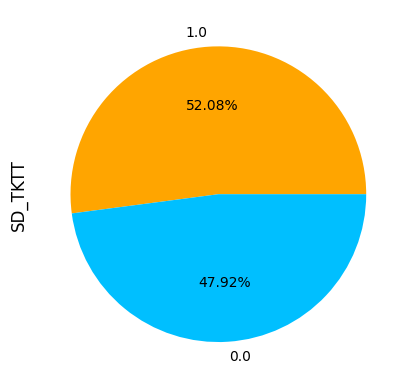

In [95]:
tmp[['CUSTOMER_CDE', 'SD_TKTT']].drop_duplicates()['SD_TKTT'].value_counts(dropna=False).plot(kind='pie', autopct='%.2f%%', colors=['orange', 'deepskyblue', 'lightgrey'])

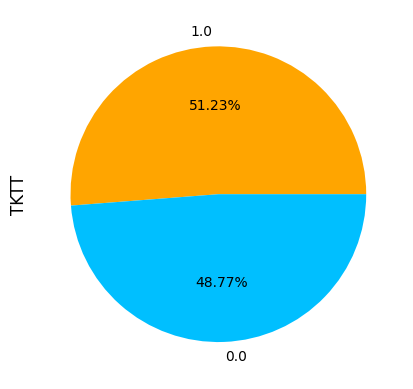

In [96]:
tmp['TKTT'].value_counts(dropna=False).loc[[1, 0]].plot(kind='pie', autopct='%.2f%%', colors=['orange', 'deepskyblue', 'lightgrey'])
plt.show()

In [97]:
tmp1 = tmp[['SD_TKTT','CUST_STATUS']].value_counts(dropna=False, normalize=True)
tmp1 = tmp1.to_frame('prop').reset_index().sort_values(by=['SD_TKTT', 'CUST_STATUS'])

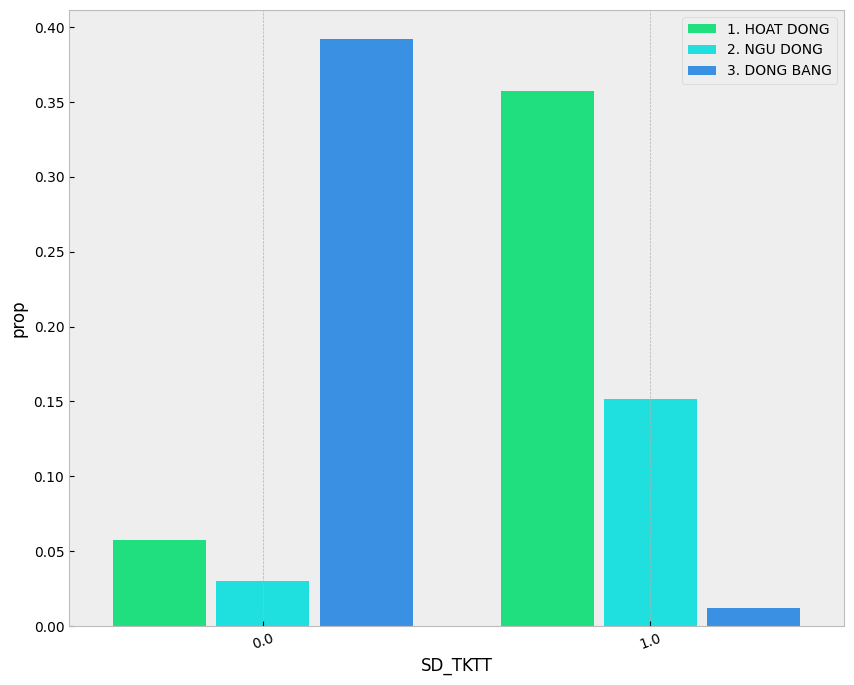

In [98]:
fig,ax=plt.subplots(1,1, figsize=(10,8))
sns.barplot(tmp1,x='SD_TKTT',hue='CUST_STATUS',y='prop',palette=['springgreen', 'cyan', 'dodgerblue'], gap=0.1, fill=True,ax=ax)
ax.tick_params(axis='x', rotation=20)
ax.legend(loc='best', )
plt.grid()
plt.show()

In [99]:
tmp.groupby(['SD_TKTT','CUST_STATUS','TKTT'])['CUSTOMER_CDE'].nunique()

SD_TKTT  CUST_STATUS   TKTT
0.0      1. HOAT DONG  0.0      27654
         2. NGU DONG   0.0      14682
         3. DONG BANG  0.0     189988
1.0      1. HOAT DONG  0.0       3914
                       1.0     169355
         2. NGU DONG   0.0        196
                       1.0      73219
         3. DONG BANG  1.0       5775
Name: CUSTOMER_CDE, dtype: int64

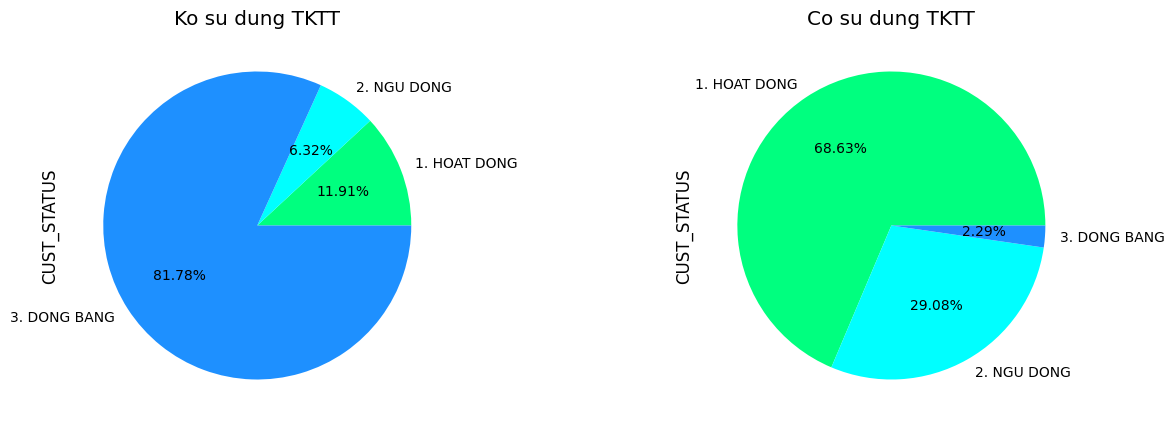

In [100]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))
tmp[tmp['SD_TKTT']==1]['CUST_STATUS'].value_counts(normalize=True).sort_index().plot(kind='pie', ax=axes[1], colors=['springgreen', 'cyan', 'dodgerblue'], autopct='%.2f%%')
tmp[tmp['SD_TKTT']==0]['CUST_STATUS'].value_counts(normalize=True).sort_index().plot(kind='pie', ax=axes[0], colors=['springgreen', 'cyan', 'dodgerblue'], autopct='%.2f%%')
axes[1].set_title('Co su dung TKTT')
axes[0].set_title('Ko su dung TKTT')
plt.show()

### DEPOSIT

In [184]:
DEPOSIT_FCT = '/opt/bitnami/jupyterhub-singleuser/hcl-quanht/feature_store/adhoc/analyse-db/DW_ANALYTICS/data/DW_DEPOSIT_FCT/SAMPLE1_SUB3'
deposit_df = pd.read_pickle(DEPOSIT_FCT)

In [185]:
deposit_df.columns

Index(['CUSTOMER_CDE', 'ACTUAL_BAL_LCL', 'PROCESS_DT', 'SUB_TERM_ID'], dtype='object')

In [186]:
# Tong so record deposit transaction 
len(deposit_df)

300341

In [187]:
deposit_df

,CUSTOMER_CDE,ACTUAL_BAL_LCL,PROCESS_DT,SUB_TERM_ID
0,5592345,22242.0,2022-12-31,NonTerm
1,7516411,2085.0,2022-12-31,NonTerm
2,4427018,5291.0,2022-12-31,NonTerm
3,4301950,708043241.0,2022-12-31,NonTerm
4,10176174,61427.0,2022-12-31,NonTerm
...,...,...,...,...
300336,5645292,251157.0,2022-12-31,NonTerm
300337,15418021,82366.0,2022-12-31,NonTerm
300338,16574825,50022.0,2022-12-31,NonTerm
300339,9488283,51370.0,2022-12-31,NonTerm


In [188]:
deposit_df['SUB_TERM_ID'].value_counts(normalize=True)

NonTerm    0.860272
12M        0.050309
6M         0.034218
1M         0.022464
3M         0.009945
15M        0.004332
2M         0.004029
84M        0.002970
24M        0.002724
36M        0.002058
99M        0.001239
7M         0.000846
60M        0.000816
4M         0.000529
1W         0.000529
9M         0.000489
18M        0.000469
5M         0.000300
8M         0.000266
10M        0.000213
>10Y       0.000203
2W         0.000190
48M        0.000176
11M        0.000176
120M       0.000083
3W         0.000060
13M        0.000047
72M        0.000017
96M        0.000013
108M       0.000010
01M        0.000003
100M       0.000003
Name: SUB_TERM_ID, dtype: float64

In [189]:
deposit_df['CUSTOMER_CDE'].nunique()

253564

In [190]:
tmp = deposit_df[deposit_df['SUB_TERM_ID']=='NonTerm'].merge(df2_1[['CUSTOMER_CDE', 'CUST_STATUS', 'TKTT', 'SD_TKTT']], how='inner', left_on='CUSTOMER_CDE', right_on='CUSTOMER_CDE')

In [191]:
tmp = tmp[tmp['ACTUAL_BAL_LCL'] > 0]

In [192]:
len(tmp)

249406

In [193]:
tmp[['CUSTOMER_CDE', 'SD_TKTT']].drop_duplicates()['SD_TKTT'].value_counts(), tmp[['CUSTOMER_CDE', 'SD_TKTT']].drop_duplicates()['SD_TKTT'].value_counts(normalize=True)

(1.0    232208
 0.0      3205
 Name: SD_TKTT, dtype: int64,
 1.0    0.986386
 0.0    0.013614
 Name: SD_TKTT, dtype: float64)

In [194]:
tmp.groupby('CUST_STATUS')['CUSTOMER_CDE'].nunique()

CUST_STATUS
1. HOAT DONG    171777
2. NGU DONG      63566
3. DONG BANG       386
Name: CUSTOMER_CDE, dtype: int64

In [195]:
tmp[tmp['SD_TKTT']==1].groupby('CUST_STATUS')['CUSTOMER_CDE'].nunique()

CUST_STATUS
1. HOAT DONG    168705
2. NGU DONG      63484
3. DONG BANG        19
Name: CUSTOMER_CDE, dtype: int64

In [197]:
tmp['ACTUAL_BAL_LCL'].isna().sum()

0

In [198]:
tmp['ACTUAL_BAL_LCL'].describe()

count    2.494060e+05
mean     6.875345e+06
std      6.890096e+07
min      1.000000e+00
25%      5.002200e+04
50%      5.708500e+04
75%      3.658452e+05
max      8.114573e+09
Name: ACTUAL_BAL_LCL, dtype: float64

In [199]:
tmp['ACTUAL_BAL_LCL'].apply(lambda x:np.log(x)).describe()

count    249406.000000
mean         11.476551
std           2.847212
min           0.000000
25%          10.820218
50%          10.952297
75%          12.809966
max          22.816927
Name: ACTUAL_BAL_LCL, dtype: float64

In [200]:
tmp.groupby('CUST_STATUS')['ACTUAL_BAL_LCL'].agg(['min','mean', 'median','max'])

,min,mean,median,max
CUST_STATUS,,,,
1. HOAT DONG,1.0,9.304044e+06,67848.0,8.114573e+09
2. NGU DONG,1.0,6.337989e+04,50616.0,3.000227e+08
3. DONG BANG,2.0,5.309688e+06,154797.5,4.211951e+08


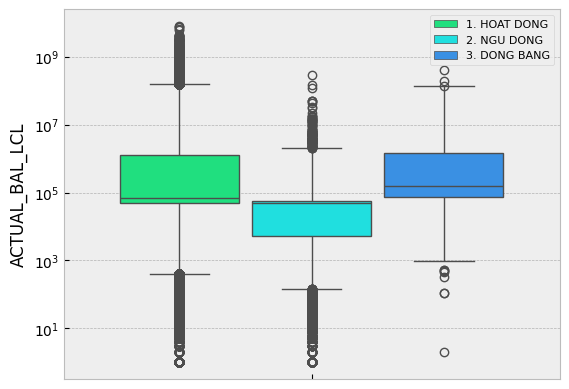

In [201]:
ax = sns.boxplot(tmp, y='ACTUAL_BAL_LCL', 
                 log_scale=True, 
                 hue='CUST_STATUS', 
            # fill=False, 
            # notch=True, showcaps=False,
            # medianprops={'color':'r'},
            palette=['springgreen', 'cyan', 'dodgerblue'], gap=.1,
                 # figsize=(7,7)
           )
ax.legend(prop={'size':8})

<Axes: xlabel='ACTUAL_BAL_LCL', ylabel='Density'>

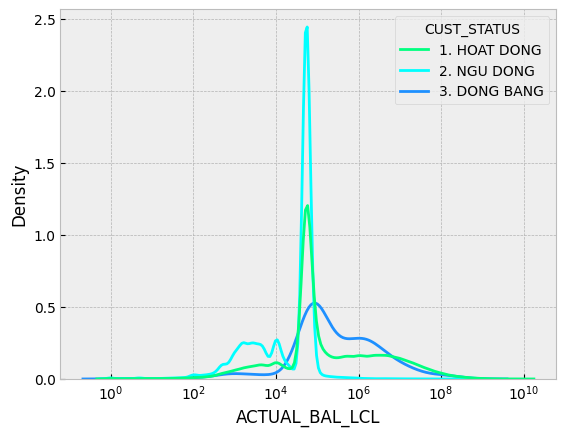

In [202]:
sns.kdeplot(tmp, x='ACTUAL_BAL_LCL',
            log_scale=True, 
            # stat='proportion', 
            hue='CUST_STATUS', 
            # element='step',
            # fill=False, 
            # cumulative=True, 
            common_norm=False,
            palette=['springgreen', 'cyan', 'dodgerblue']
            )

In [120]:
tmp1 = tmp.groupby(['TKTT','CUST_STATUS', 'CUSTOMER_CDE'])['ACTUAL_BAL_LCL'].sum().reset_index()
tmp1['ACTUAL_BAL_LCL'] = tmp1['ACTUAL_BAL_LCL'].apply(lambda x:np.log(x))

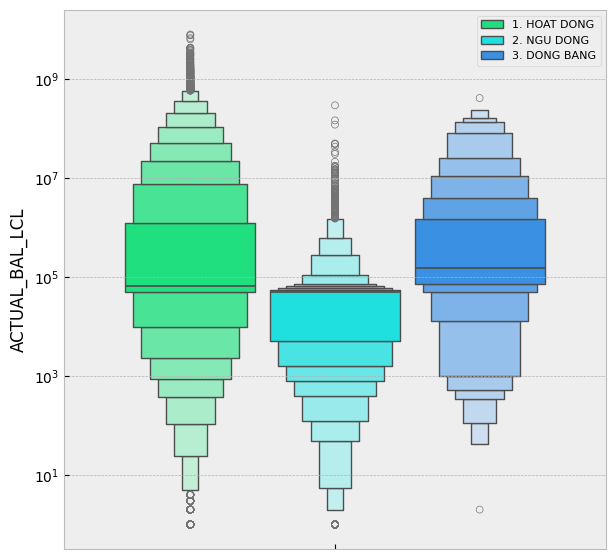

In [153]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
sns.boxenplot(tmp, hue='CUST_STATUS', y='ACTUAL_BAL_LCL', width_method='linear',palette=['springgreen', 'cyan', 'dodgerblue'], gap=.1,
              ax=ax,
              log_scale=True,
              k_depth='proportion', 
              # medianprops={'color':'r'},
             )
ax.legend(prop={'size':8})
plt.show()

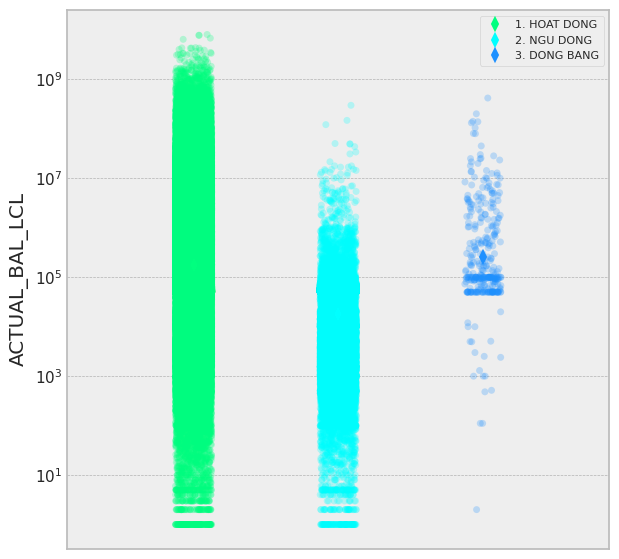

In [182]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
sns.stripplot(tmp, hue='CUST_STATUS', y='ACTUAL_BAL_LCL', 
              dodge=True,
              # zorder=1,
              palette=['springgreen', 'cyan', 'dodgerblue'], 
              ax=ax,
              log_scale=True,
              alpha=.25,
              legend=False
             )
sns.pointplot(tmp, hue='CUST_STATUS', y='ACTUAL_BAL_LCL',
              dodge=.8 - .8/3, errorbar=None, 
              palette=['springgreen', 'cyan', 'dodgerblue'], 
              markers='d', markersize=4, linestyle='none'
             )
ax.legend(prop={'size':8})
plt.show()

### SUB_TERM

In [302]:
tmp = deposit_df.copy()
tmp1 = cust_status.copy()

In [303]:
tmp = tmp.merge(cust_status, how='inner', left_on='CUSTOMER_CDE', right_on='CUSTOMER_CDE')

In [304]:
tmp[tmp['SUB_TERM_ID']=='100M']['CUST_TYPE'].value_counts()

CN    1
Name: CUST_TYPE, dtype: int64

In [305]:
tmp['SUB_TERM_ID'].value_counts(normalize=True)

NonTerm    0.860336
12M        0.050316
6M         0.034222
1M         0.022468
3M         0.009947
15M        0.004332
2M         0.004029
84M        0.002970
24M        0.002724
36M        0.002058
99M        0.001239
7M         0.000846
60M        0.000816
4M         0.000529
9M         0.000490
18M        0.000470
1W         0.000446
5M         0.000300
8M         0.000266
10M        0.000213
>10Y       0.000203
2W         0.000190
11M        0.000176
48M        0.000176
120M       0.000083
3W         0.000060
13M        0.000047
72M        0.000017
96M        0.000013
108M       0.000010
01M        0.000003
100M       0.000003
Name: SUB_TERM_ID, dtype: float64

In [307]:
tmp.groupby('SUB_TERM_ID')['ACTUAL_BAL_LCL'].agg(['max','min', 'mean', 'median'])

,max,min,mean,median
SUB_TERM_ID,,,,
01M,8.419930e+05,8.419930e+05,8.419930e+05,841993.0
100M,3.140307e+07,3.140307e+07,3.140307e+07,31403069.0
108M,1.375000e+07,1.000000e+05,5.116667e+06,1500000.0
10M,3.000000e+08,0.000000e+00,3.372132e+07,10747916.0
11M,8.500000e+09,0.000000e+00,2.498546e+08,22000000.0
120M,7.000000e+07,1.000000e+05,1.279872e+07,4818439.0
12M,1.350000e+11,-6.429452e+07,2.795537e+08,50000000.0
13M,1.500274e+09,0.000000e+00,2.472782e+08,75000000.0
15M,1.100000e+10,-3.206411e+07,5.344120e+08,100000000.0


In [300]:
tmp['ACTUAL_BAL_LCL'].describe()

count    2.934800e+05
mean     4.060097e+07
std      6.945645e+08
min     -2.782242e+10
25%      5.002200e+04
50%      6.024650e+04
75%      1.431671e+06
max      2.193200e+11
Name: ACTUAL_BAL_LCL, dtype: float64

<Axes: xlabel='ACTUAL_BAL_LCL', ylabel='Density'>

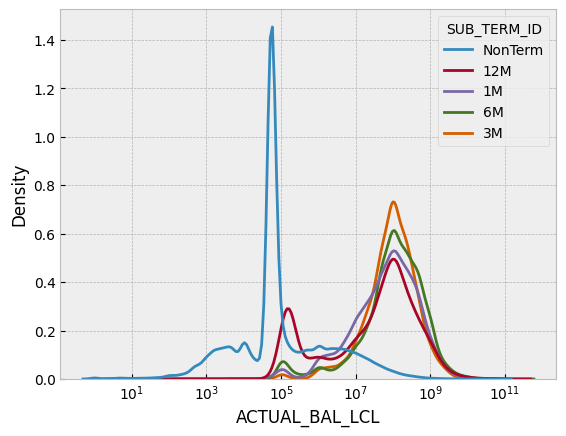

In [311]:
sns.kdeplot(tmp, x='ACTUAL_BAL_LCL', 
            hue='SUB_TERM_ID', 
            log_scale=True,
            # multiple='fill',
            # bw_adjust=.2
            # palette=['springgreen', 'cyan', 'dodgerblue'], 
            # legend=False,
            # fill=True,
            common_norm=False,
            # native_scale=True,
            # col='CUST_STATUS',
           )

In [327]:
tmp = tmp[(tmp['SUB_TERM_ID'].isin(['NonTerm', 
                                   '12M', 
                                   '6M', 
                                   # '1M', 
                                   # '3M'
                                  ])) & 
          (tmp['ACTUAL_BAL_LCL'] > 0)
         ]

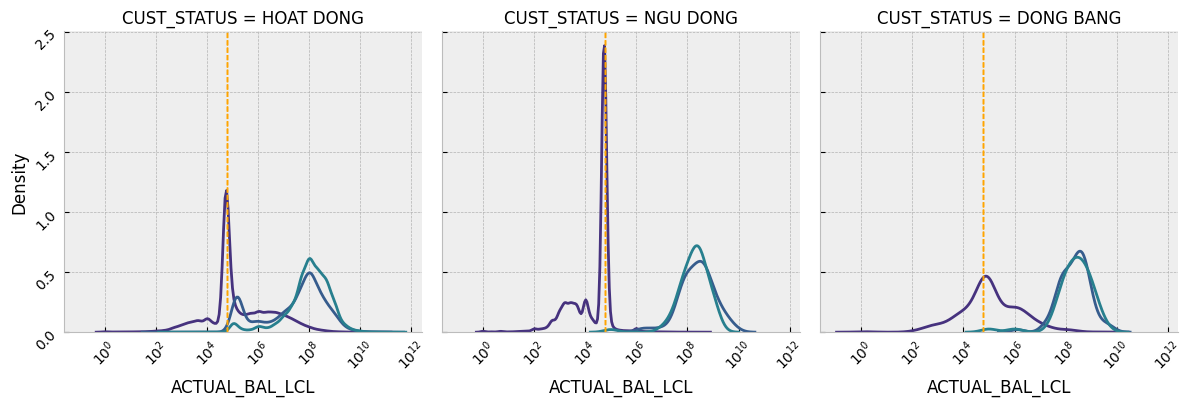

In [341]:
g = sns.FacetGrid(tmp, 
                  col='CUST_STATUS', 
                  hue='SUB_TERM_ID', 
                  palette=sns.color_palette('viridis'),
                  # palette=['springgreen', 'cyan', 'dodgerblue'], 
                  # row='TRAN_STATUS', 
                  margin_titles=True, despine=True, height=4, aspect=1,
                  
                 )
g.map_dataframe(sns.kdeplot, 
                x='ACTUAL_BAL_LCL',
                common_norm=False,
                log_scale=True,
                legend=True,
               )
g.refline(x=tmp['ACTUAL_BAL_LCL'].median(),lw=1, c='orange')
# g.figure.subplots_adjust(wspace=0, hspace=0)
for ax in g.figure.axes:
    ax.tick_params(labelrotation=45)

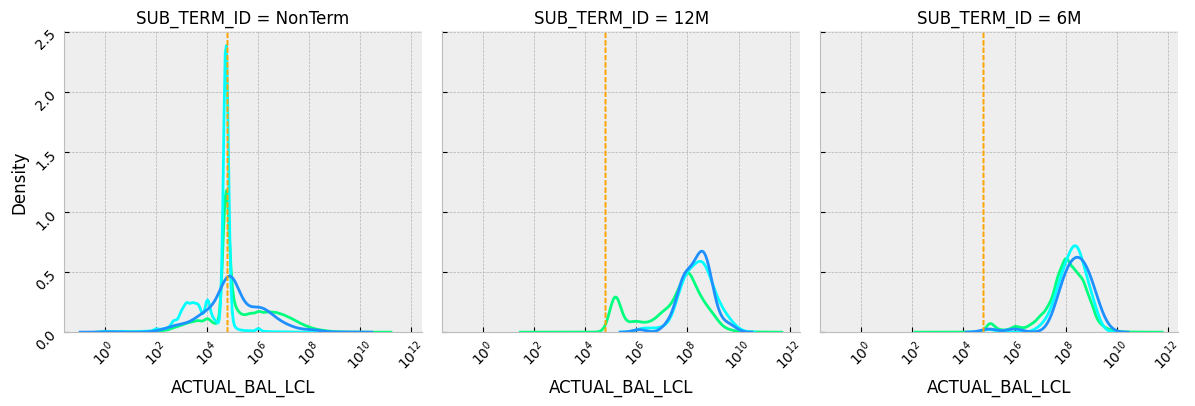

In [342]:
g = sns.FacetGrid(tmp, 
                  col='SUB_TERM_ID', 
                  hue='CUST_STATUS', 
                  # palette=sns.color_palette('viridis'),
                  palette=['springgreen', 'cyan', 'dodgerblue'], 
                  # row='TRAN_STATUS', 
                  margin_titles=True, despine=True, height=4, aspect=1)
g.map_dataframe(sns.kdeplot, 
                x='ACTUAL_BAL_LCL',
                common_norm=False,
                log_scale=True,
                legend=True,
               )
g.refline(x=tmp['ACTUAL_BAL_LCL'].median(), lw=1, c='orange')
# g.figure.subplots_adjust(wspace=0, hspace=0)
for ax in g.figure.axes:
    ax.tick_params(labelrotation=45)

### TXN AMT

In [265]:
# bao gom thong tin giao dich cua khach hang
stmt_ebank_df = pd.read_pickle('/opt/bitnami/jupyterhub-singleuser/hcl-quanht/feature_store/adhoc/analyse-db/DW_ANALYTICS/data/DWA_STMT_EBANK/SAMPLE1_SUB3')

In [185]:
stmt_ebank_df.columns

Index(['BANK_ID', 'STMT_ENTRY_ID', 'ACCOUNT_NUMBER', 'COMPANY_CODE', 'AMT_LCY',
       'TRANSACTION_CODE', 'THEIR_REFERENCE', 'NARRATIVE', 'PL_CATEGORY',
       'CUSTOMER_ID', 'PRODUCT_CATEGORY', 'VALUE_DATE', 'CURRENCY',
       'AMOUNT_FCY', 'OUR_REFERENCE', 'REVERSAL_MARKER', 'TRANS_REFERENCE',
       'BOOKING_DATE', 'DATE_TIME', 'GIO', 'OPEN_BAL', 'ONLINE_CUR_BAL',
       'CHINHANH', 'BRANCH_CODE', 'PROCESS_DT', 'CLOSE_BAL', 'DATE_ORDER',
       'CLOSE_BAL_FIELD5', 'SENDERS_NAME', 'LEGAL_ID', 'ADDRESS', 'TAX_CODE',
       'SENDERS_ACCT', 'AT_BANK', 'CUSTOMER_SEND_CDE', 'INPUTTER', 'AUTHOR_ID',
       'PRODUCT_CATEGORY_2', 'ALT_ACCT_ID', 'CUSTOMER_CDE', 'BANK_ID',
       'TRANSACTION_CODE', 'NARRATIVE', 'DATA_CAPTURE', 'CHEQUE_IND',
       'MANDATORY_REF_NO', 'DEBIT_CREDIT_IND', 'CHARGE_KEY',
       'IMMEDIATE_CHARGE', 'DEFAULT_VALUE_DATE', 'EXPOSURE_DATE',
       'TURNOVER_CHARGE', 'SWIFT_NARRATIVE', 'UNIT_COST', 'INITIATION',
       'SHORT_DESC', 'STMT_NARR', 'STMT_NARR_REF', 'FORC

In [186]:
# stmt_ebank_df = stmt_ebank_df[['AMT_LCY', 'CUSTOMER_ID', 'PROCESS_DT']]

In [187]:
# sorted(stmt_ebank_df['PROCESS_DT'].unique())

In [188]:
stmt_ebank_df.groupby('PROCESS_DT')['CUSTOMER_ID'].nunique().to_frame()

,CUSTOMER_ID
PROCESS_DT,
2021-12-31,27552
2022-01-31,36450
2022-02-28,35589
2022-03-31,25141
2022-04-30,31563
2022-05-31,28333
2022-06-30,27983
2022-09-02,24022
2022-09-29,27884


In [189]:
tmp = stmt_ebank_df[['AMT_LCY', 'CUSTOMER_ID', 'PROCESS_DT']].copy()

In [190]:
tmp1 = df3.copy().drop(columns=['PROCESS_DT'])

In [191]:
df3['CUST_STATUS'].value_counts()

1. HOAT DONG    200929
3. DONG BANG    195763
2. NGU DONG      88097
Name: CUST_STATUS, dtype: int64

In [192]:
tmp['CUSTOMER_ID'] = tmp['CUSTOMER_ID'].astype(str)

In [193]:
tmp2 = tmp.merge(tmp1, how='inner', left_on='CUSTOMER_ID', right_on='CUSTOMER_CDE')

In [194]:
tmp2['TXN_TYPE'] = tmp2['AMT_LCY'].apply(lambda x: "OUT" if x < 0 else "IN")

In [195]:
tmp2['ABS_AMT_LCY'] = abs(tmp2['AMT_LCY'])

In [196]:
tmp2[tmp2['AMT_LCY']==0]

,AMT_LCY,CUSTOMER_ID,PROCESS_DT,CUSTOMER_CDE,CUST_TYPE,CUST_STATUS,BH,IB,MB,PAY,...,CUST_OPEN_DT,RATE_LEVEL_NAME,BIRTHDAY,MATRIMONY_STATUS,GENDER_CDE,PROVINCE_NM,CUS_OPEN_DT,DB_GRP_CIC,TXN_TYPE,ABS_AMT_LCY


In [197]:
# no txn zero amount

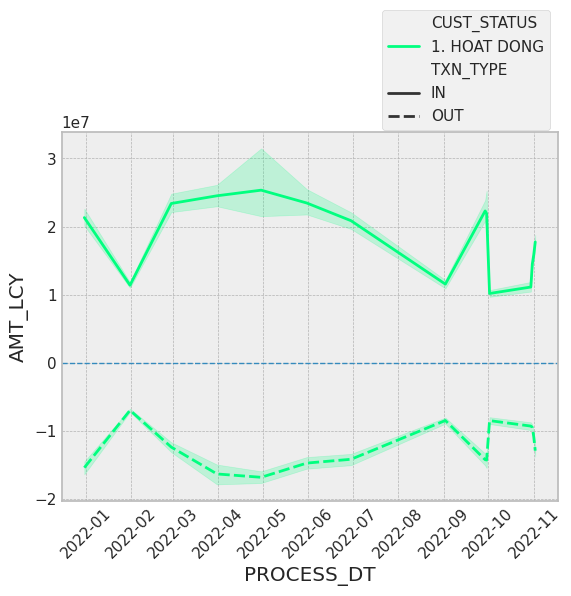

In [198]:
ax = sns.lineplot(tmp2, x='PROCESS_DT', y='AMT_LCY', hue='CUST_STATUS', palette=['springgreen', 'cyan', 'dodgerblue'], 
                  style='TXN_TYPE', 
                  # markers=True,
                  orient='x')
# sns.pointplot(tmp2, x='PROCESS_DT', y='AMT_LCY', palette=['springgreen', 'cyan', 'dodgerblue'], hue='CUST_STATUS', ax=ax)
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='upper right', bbox_to_anchor=(1,1.35))
plt.axhline(ls='--',lw=1)

In [199]:
tmp3 = tmp2.groupby(['CUST_STATUS','PROCESS_DT'])['AMT_LCY'].sum()
tmp3 = tmp3.to_frame('NET_AMT').reset_index()
# sns.regplot(tmp3, x='PROCESS_DT', y='NET_AMT')

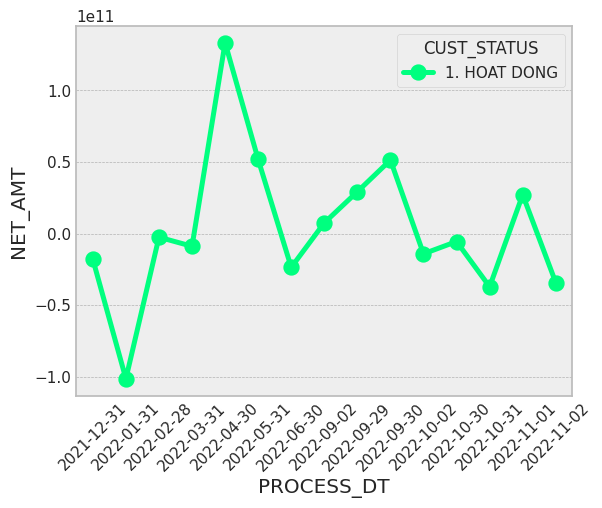

In [200]:
ax = sns.pointplot(tmp3, x='PROCESS_DT', y='NET_AMT', palette=['springgreen', 'cyan', 'dodgerblue'], hue='CUST_STATUS')
ax.tick_params(axis='x', rotation=45)

In [201]:
tmp3 = tmp2.groupby(['CUST_STATUS','CUSTOMER_CDE', 'TXN_TYPE'])['ABS_AMT_LCY'].max()
tmp3 = tmp3.to_frame(name='MAX_AMT').reset_index()

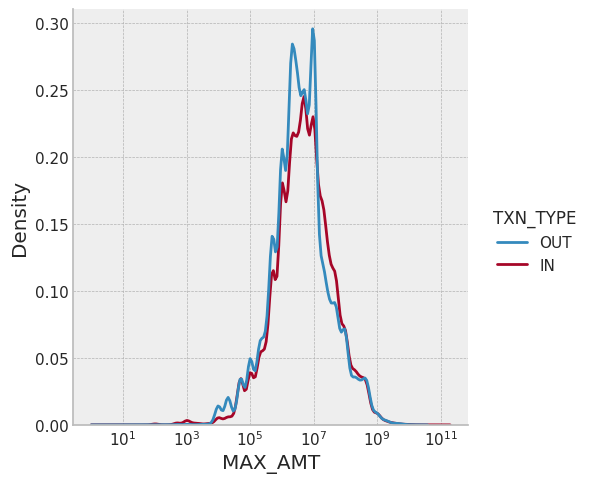

In [202]:
sns.displot(data=tmp3, x='MAX_AMT', hue='TXN_TYPE', kind='kde',multiple='layer', clip=(0, None), log_scale=True,
            # palette=['springgreen', 'cyan', 'dodgerblue'], 
           )

In [203]:
tmp3 = tmp2.sort_values(by=['PROCESS_DT'], ascending=False)

In [204]:
tmp2['CUST_STATUS'].value_counts()

1. HOAT DONG    1288465
Name: CUST_STATUS, dtype: int64

In [205]:
tmp4 = tmp3[(tmp3['TXN_TYPE']=='OUT') & (tmp3['CUST_STATUS']=='1. HOAT DONG')]
tmp5 = tmp3[(tmp3['TXN_TYPE']=='IN')& (tmp3['CUST_STATUS']=='1. HOAT DONG')]

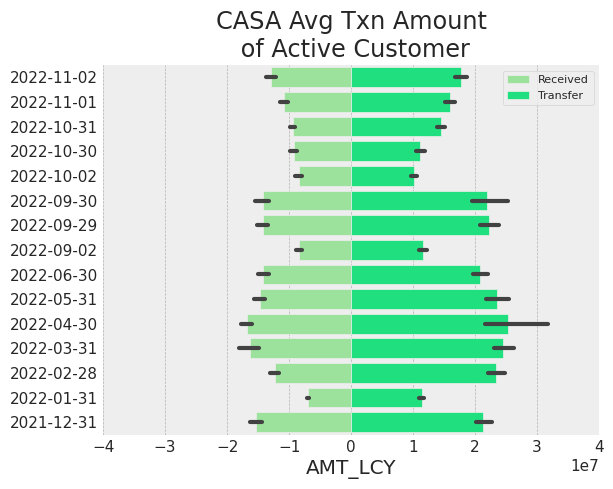

In [206]:
fig, ax = plt.subplots(1,1, )
sns.set_color_codes('pastel')
sns.barplot(tmp4, x='AMT_LCY', y='PROCESS_DT', errorbar='ci', label='Received', color='lightgreen',ax=ax)
sns.set_color_codes('muted')
sns.barplot(tmp5, x='AMT_LCY', y='PROCESS_DT', errorbar='ci', ax=ax, label='Transfer', color='springgreen')
ax.legend(prop={'size': 8})
ax.set(xlim=(-4*1e7, 4*1e7), ylabel="")
ax.set_title('CASA Avg Txn Amount\n of Active Customer')
sns.despine(left=True, bottom=True)
plt.show()


### NARRATIVE

In [207]:
from wordcloud import WordCloud

In [208]:
tmp = stmt_ebank_df.copy()
tmp.columns

Index(['BANK_ID', 'STMT_ENTRY_ID', 'ACCOUNT_NUMBER', 'COMPANY_CODE', 'AMT_LCY',
       'TRANSACTION_CODE', 'THEIR_REFERENCE', 'NARRATIVE', 'PL_CATEGORY',
       'CUSTOMER_ID', 'PRODUCT_CATEGORY', 'VALUE_DATE', 'CURRENCY',
       'AMOUNT_FCY', 'OUR_REFERENCE', 'REVERSAL_MARKER', 'TRANS_REFERENCE',
       'BOOKING_DATE', 'DATE_TIME', 'GIO', 'OPEN_BAL', 'ONLINE_CUR_BAL',
       'CHINHANH', 'BRANCH_CODE', 'PROCESS_DT', 'CLOSE_BAL', 'DATE_ORDER',
       'CLOSE_BAL_FIELD5', 'SENDERS_NAME', 'LEGAL_ID', 'ADDRESS', 'TAX_CODE',
       'SENDERS_ACCT', 'AT_BANK', 'CUSTOMER_SEND_CDE', 'INPUTTER', 'AUTHOR_ID',
       'PRODUCT_CATEGORY_2', 'ALT_ACCT_ID', 'CUSTOMER_CDE', 'BANK_ID',
       'TRANSACTION_CODE', 'NARRATIVE', 'DATA_CAPTURE', 'CHEQUE_IND',
       'MANDATORY_REF_NO', 'DEBIT_CREDIT_IND', 'CHARGE_KEY',
       'IMMEDIATE_CHARGE', 'DEFAULT_VALUE_DATE', 'EXPOSURE_DATE',
       'TURNOVER_CHARGE', 'SWIFT_NARRATIVE', 'UNIT_COST', 'INITIATION',
       'SHORT_DESC', 'STMT_NARR', 'STMT_NARR_REF', 'FORC

In [209]:
# stmt_ebank_df[['AMT_LCY', 'CUSTOMER_ID', 'PROCESS_DT']].copy()
tmp = tmp[['NARRATIVE', 'CUSTOMER_ID', 'PROCESS_DT','AMT_LCY']]

In [210]:
tmp.columns = ['NARRATIVE','S_NARRATIVE','CUSTOMER_ID', 'PROCESS_DT','AMT_LCY']

In [211]:
tmp1 = df3.copy().drop(columns=['PROCESS_DT'])

In [212]:
tmp1['CUST_STATUS'].value_counts()

1. HOAT DONG    200929
3. DONG BANG    195763
2. NGU DONG      88097
Name: CUST_STATUS, dtype: int64

In [213]:
tmp['CUSTOMER_ID'] = tmp['CUSTOMER_ID'].astype(str)

In [214]:
tmp2 = tmp.merge(tmp1, how='inner', left_on='CUSTOMER_ID', right_on='CUSTOMER_CDE')

In [215]:
tmp2['TXN_TYPE'] = tmp2['AMT_LCY'].apply(lambda x: "OUT" if x < 0 else "IN")

In [216]:
tmp2['ABS_AMT_LCY'] = abs(tmp2['AMT_LCY'])

In [217]:
tmp3 = tmp2[['NARRATIVE', 'CUSTOMER_CDE','CUST_STATUS', 'TXN_TYPE']]

In [218]:
tmp4 = tmp3.groupby([ 'CUST_STATUS', 'TXN_TYPE'])['NARRATIVE'].apply(lambda x: ' '.join(list(x)))

In [219]:
tmp4

CUST_STATUS   TXN_TYPE
1. HOAT DONG  IN          MBVCB.2403496542.316329.khanh chuyen tien.CT t...
              OUT         EWX289651148 IBFT NGUYEN THI LIA chuyen tien  ...
Name: NARRATIVE, dtype: object

(-0.5, 399.5, 199.5, -0.5)

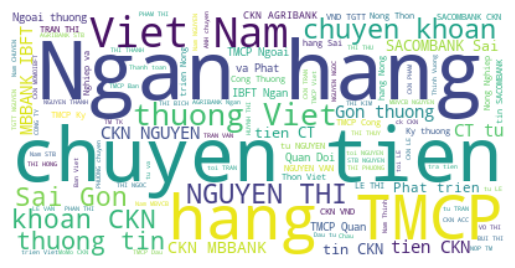

In [220]:
wordcloud_img = WordCloud(background_color='white').generate(tmp4[0])
plt.imshow(wordcloud_img, interpolation='bilinear')
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

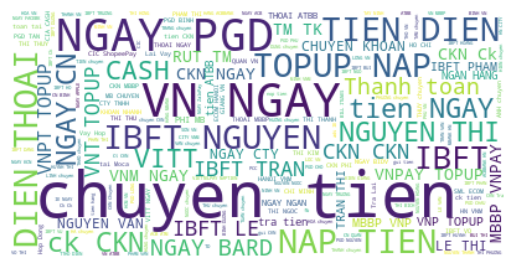

In [221]:
wordcloud_img = WordCloud(background_color='white').generate(tmp4[1])
plt.imshow(wordcloud_img, interpolation='bilinear')
plt.axis('off')

## CARD-CREDIT

In [222]:
tmp = df3.copy()

In [223]:
tmp['CUSTOMER_CDE'].nunique()

484783

In [224]:
tmp['PROCESS_DT'].unique()

array(['2022-11-18T00:00:00.000000000'], dtype='datetime64[ns]')

In [225]:
tmp['SD_CREDIT'] = tmp['SD_CREDIT'].fillna(0)

In [226]:
tmp['CREDIT'] = tmp['CREDIT'].fillna(0)

<Axes: ylabel='SD_CREDIT'>

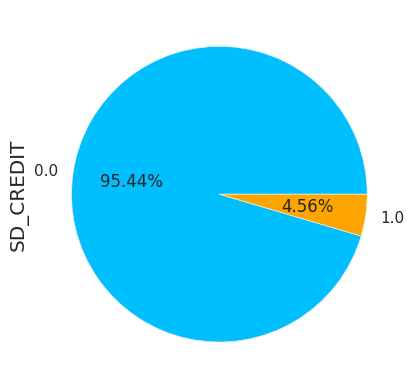

In [227]:
tmp[['CUSTOMER_CDE', 'SD_CREDIT']].drop_duplicates()['SD_CREDIT'].value_counts(dropna=False).sort_index().plot(kind='pie', autopct='%.2f%%', colors=['deepskyblue', 'orange'])

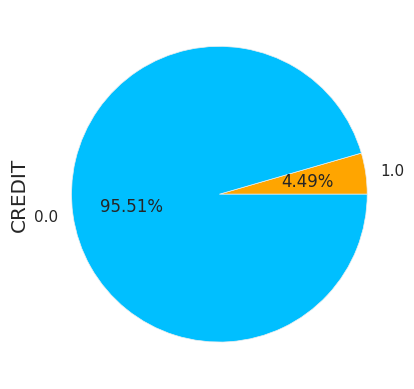

In [228]:
tmp['CREDIT'].value_counts(dropna=False).loc[[1, 0]].plot(kind='pie', autopct='%.2f%%', colors=['orange', 'deepskyblue', 'lightgrey'])
plt.show()

In [229]:
tmp1 = tmp[['SD_CREDIT','CUST_STATUS']].value_counts(dropna=False, normalize=True)
tmp1 = tmp1.to_frame('prop').reset_index().sort_values(by=['SD_CREDIT', 'CUST_STATUS'])

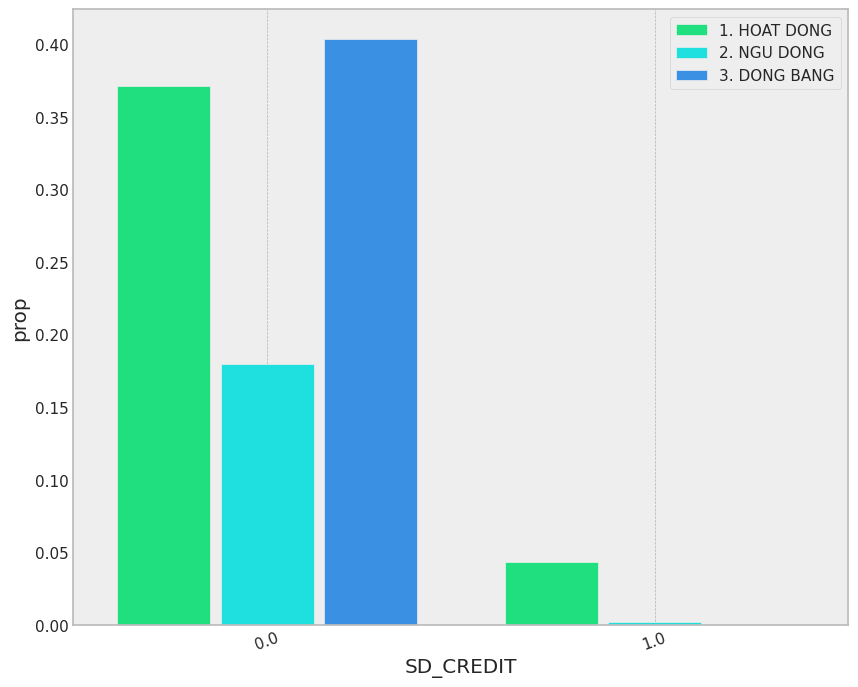

In [230]:
fig,ax=plt.subplots(1,1, figsize=(10,8))
sns.barplot(tmp1,x='SD_CREDIT',hue='CUST_STATUS',y='prop',palette=['springgreen', 'cyan', 'dodgerblue'], gap=0.1, fill=True,ax=ax)
ax.tick_params(axis='x', rotation=20)
ax.legend(loc='best', )
plt.grid()
plt.show()

In [231]:
tmp.groupby(['SD_CREDIT','CUST_STATUS','CREDIT'])['CUSTOMER_CDE'].nunique()

SD_CREDIT  CUST_STATUS   CREDIT
0.0        1. HOAT DONG  0.0       179773
           2. NGU DONG   0.0        87119
           3. DONG BANG  0.0       195762
1.0        1. HOAT DONG  0.0          377
                         1.0        20773
           2. NGU DONG   1.0          978
           3. DONG BANG  1.0            1
Name: CUSTOMER_CDE, dtype: int64

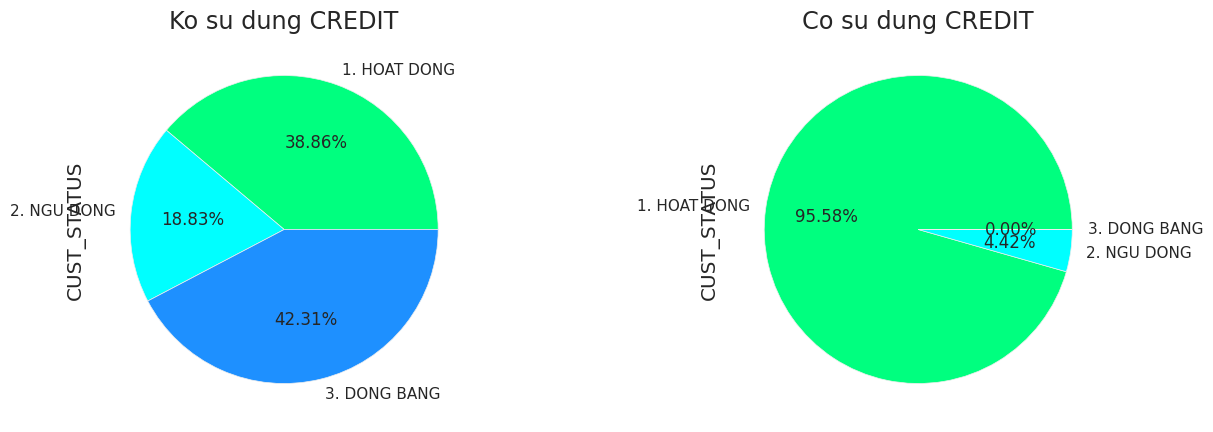

In [232]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))
tmp[tmp['SD_CREDIT']==1]['CUST_STATUS'].value_counts(normalize=True).sort_index().plot(kind='pie', ax=axes[1], colors=['springgreen', 'cyan', 'dodgerblue'], autopct='%.2f%%')
tmp[tmp['SD_CREDIT']==0]['CUST_STATUS'].value_counts(normalize=True).sort_index().plot(kind='pie', ax=axes[0], colors=['springgreen', 'cyan', 'dodgerblue'], autopct='%.2f%%')
axes[1].set_title('Co su dung CREDIT')
axes[0].set_title('Ko su dung CREDIT')
plt.show()

### CARD_CREDIT BAL NOW

In [203]:
CARD_CREDIT_SUM_BAL_NOW = """SELECT CUSTOMER_CDE,
        SUM(TT_ORIGINAL_BALANCE) CARD_CREDIT_SUM_BAL_NOW,
        TO_DATE('02-11-22', 'DD-MM-YY') AS RPT_DT
FROM
  (SELECT BAL.*,
          ROW_NUMBER() OVER(PARTITION BY CUSTOMER_CDE, CARD_CDE
                            ORDER BY PROCESS_DT DESC) RN
   FROM
     (SELECT CUSTOMER_CDE,
             CARD_CDE,
             TT_ORIGINAL_BALANCE,
             PROCESS_DT
      FROM DW_ANALYTICS.DATA_RPT_CARD_493 CC
      WHERE PROCESS_DT < TO_DATE('02-11-22', 'DD-MM-YY')
        AND CUSTOMER_CDE IN
          (SELECT CUSTOMER_CDE
           FROM CINS_TMP_ALY_CUST_SAMPLE1_SUB3)
        AND CARD_CDE LIKE '3%' ) BAL) BAL
WHERE RN = 1
GROUP BY CUSTOMER_CDE"""

In [204]:
card_credit_bal_now = download_or_reload('data/card_credit_bal_now', CARD_CREDIT_SUM_BAL_NOW)

Len 26869


In [205]:
26869 / 500000 * 100

5.3738

In [206]:
tmp = card_credit_bal_now.copy()

In [207]:
tmp1 = cust_status.copy()

In [208]:
tmp = tmp.merge(tmp1, how='inner', left_on='CUSTOMER_CDE', right_on='CUSTOMER_CDE')

<Axes: xlabel='CARD_CREDIT_SUM_BAL_NOW', ylabel='Density'>

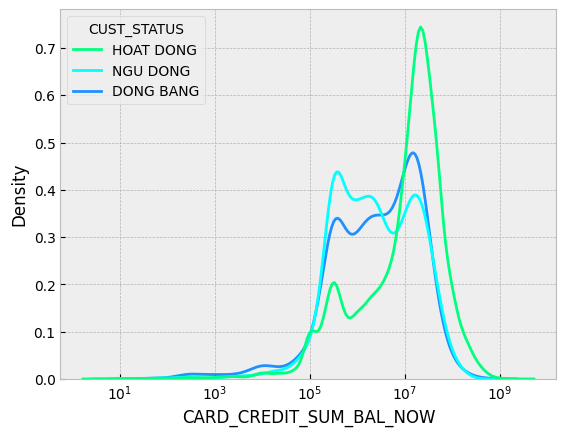

In [209]:
sns.kdeplot(tmp, x='CARD_CREDIT_SUM_BAL_NOW', log_scale=True, hue='CUST_STATUS', palette=['springgreen', 'cyan', 'dodgerblue'], common_norm=False)

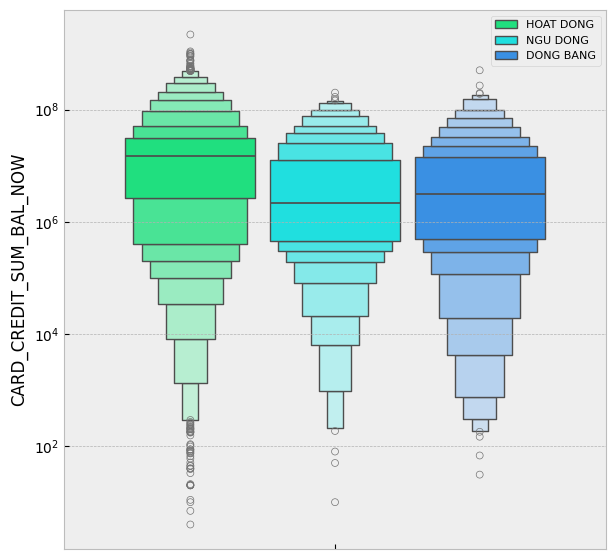

In [210]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
sns.boxenplot(tmp, hue='CUST_STATUS', y='CARD_CREDIT_SUM_BAL_NOW', width_method='linear',palette=['springgreen', 'cyan', 'dodgerblue'], gap=.1,
              ax=ax,
              log_scale=True,
              k_depth='proportion', 
              # medianprops={'color':'r'},
             )
ax.legend(prop={'size':8})
plt.show()

### CARD_TXN

In [154]:
tmp = df3.copy()

In [155]:
card_txn.TRAN_STATUS.value_counts(dropna=False)

S    1854980
F    1541478
Name: TRAN_STATUS, dtype: int64

In [156]:
# card_txn = card_txn[card_txn['TRAN_STATUS']=='S']

In [157]:
card_txn.columns

Index(['COMPANY_KEY', 'COMPANY_CDE', 'SUB_BRANCH_KEY', 'SUB_BRANCH_CDE',
       'CARD_KEY', 'CARD_CDE', 'CARDHDR_NO', 'LATEST_CARDNO', 'CUSTOMER_KEY',
       'CUSTOMER_CDE', 'SUB_SECTOR_CDE', 'DAO_KEY', 'DAO_CDE',
       'SUB_INDUSTRY_CDE', 'DECISION_CDE', 'MERCHANT_CDE', 'TXN_CURR_CDE',
       'BILL_CURR_CDE', 'PRODUCT_KEY', 'PRODUCT_CDE', 'MCC_CDE',
       'POS_COND_CDE', 'POSMODE_CDE', 'ACQ_CNTRY_CDE', 'TERMINAL_ID',
       'RESPONSE_CDE', 'TXN_OL_CDE', 'TXN_OM_CDE', 'TRXN_CAT', 'REFERRAL_CDE',
       'RETRVL_REFNO', 'ACCOUNT_NO', 'FIN_ACCTNO', 'APPROVAL_CDE',
       'ACQUIRER_REFNO', 'POST_DT', 'REQUEST_DT', 'REQUEST_TIME',
       'PARTICULARS', 'OFFICER_ID', 'SOURCE_CHANNEL', 'POS_INFO',
       'TRAN_STATUS', 'MATCH_FLAG', 'SRC_IND', 'TRXN_ID', 'TID_TRAN_IND',
       'ACCOUNT_CREDIT', 'AMT_TXN', 'AMT_BILL', 'AMT_TXN_LCL', 'AMT_FEE',
       'FOREX_MARKUP_AMT', 'MULT_NUM', 'MULT_CNT', 'PROCESS_DT',
       'REC_CREATE_DT', 'REC_UPDATE_DT', 'ROW_WID'],
      dtype='object')

In [158]:
tmp1 = tmp.merge(card_txn, how='inner', left_on='CUSTOMER_CDE', right_on='CUSTOMER_CDE')

In [159]:
tmp1['SD_CREDIT'].fillna(0, inplace=True)

In [160]:
# tmp1 = tmp[tmp['SD_CREDIT']==1].merge(card_txn, how='inner', left_on='CUSTOMER_CDE', right_on='CUSTOMER_CDE')

In [161]:
tmp1['SD_CREDIT'].value_counts(dropna=False)

0.0    2502412
1.0     883993
Name: SD_CREDIT, dtype: int64

In [162]:
tmp1['LOG_AMT_BILL'] = np.log10(tmp1['AMT_BILL'])

In [163]:
# ax = sns.relplot(tmp1, x='PROCESS_DT_y', y='LOG_AMT_BILL', 
#                  hue='CUST_STATUS', 
#                  palette=['springgreen', 'cyan', 'dodgerblue'], 
#                  col='SD_CREDIT',
#                  kind='line',
#                  # native_scale=True,
#                  # log_scale=True,
#                 )
# ax.tick_params(axis='x', rotation=60)
# # ax.set_ylim([None, None])
# plt.show()

In [164]:
tmp2 = tmp1.groupby(['PROCESS_DT_y', 'CUST_STATUS', 'CUSTOMER_CDE', 'SD_CREDIT', 'TRAN_STATUS'])['AMT_BILL'].sum().to_frame().reset_index()

In [165]:
tmp2 = tmp2.rename(columns={'PROCESS_DT_y': 'PROCESS_DT'})

In [166]:
tmp2['PROCESS_DT'] = pd.to_datetime(tmp2['PROCESS_DT'])

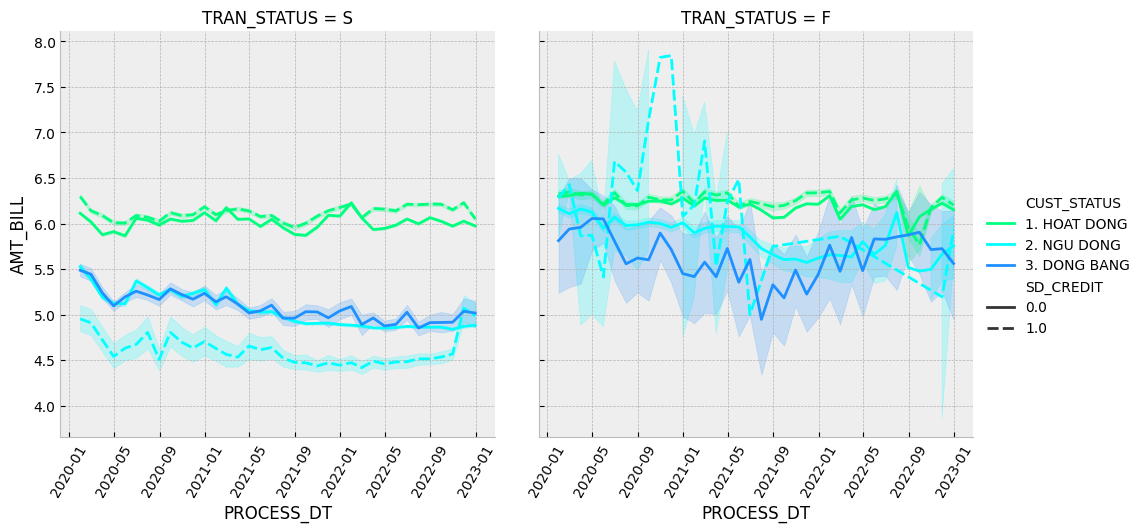

In [167]:
tmp3 = tmp2.groupby([pd.Grouper(key='PROCESS_DT', axis=0,freq='1M', sort=True), 'CUST_STATUS', 'CUSTOMER_CDE', 'SD_CREDIT', 'TRAN_STATUS'])['AMT_BILL'].sum().reset_index()
tmp3['AMT_BILL'] = np.log10(tmp3['AMT_BILL'])

ax = sns.relplot(tmp3, x='PROCESS_DT', y='AMT_BILL', hue='CUST_STATUS', palette=['springgreen', 'cyan', 'dodgerblue'], 
                  style='SD_CREDIT',
                 kind='line',
                 col='TRAN_STATUS',
                 # native_scale=True,
                 # log_scale=True,
                )
ax.tick_params(axis='x', rotation=60)
# ax.set_ylim([None, None])
plt.show()

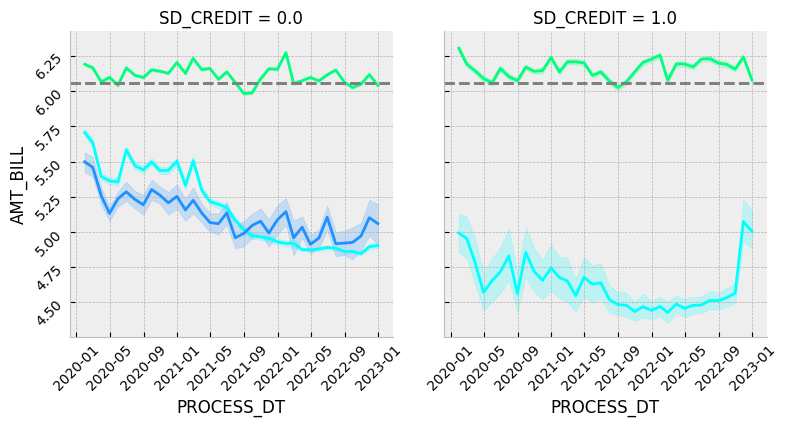

In [169]:
g = sns.FacetGrid(tmp3, 
                  col='SD_CREDIT', 
                  hue='CUST_STATUS', palette=['springgreen', 'cyan', 'dodgerblue'], 
                  # row='TRAN_STATUS', 
                  margin_titles=True, despine=True, height=4, aspect=1)
g.map_dataframe(sns.lineplot, x='PROCESS_DT', y='AMT_BILL')
g.refline(y=tmp3['AMT_BILL'].median())
# g.figure.subplots_adjust(wspace=0, hspace=0)
for ax in g.figure.axes:
    ax.tick_params(labelrotation=45)
# plt.xticks(rotation=45)

# REACTIVATED

In [247]:
reactivated_data['REACTIVATED'] = (reactivated_data['CUST_STT'] == 2) & (reactivated_data['CUST_STT_CHG'] == 1)

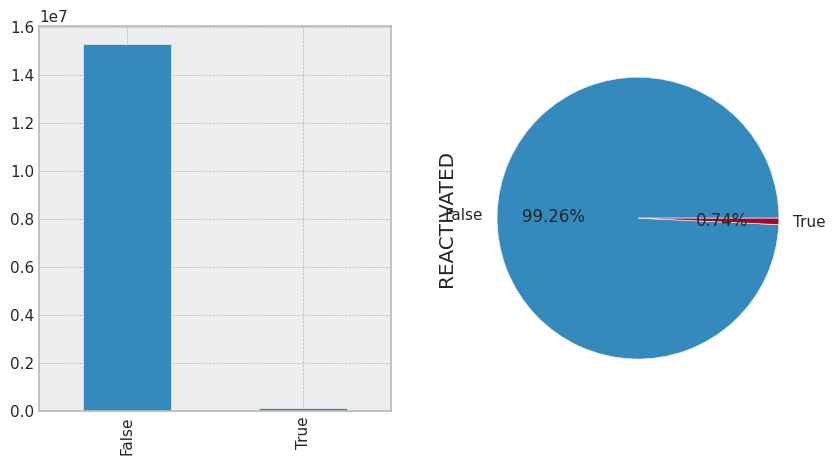

In [248]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
reactivated_data['REACTIVATED'].value_counts().plot(kind='bar', ax=axes[0])
reactivated_data['REACTIVATED'].value_counts().plot(kind='pie',autopct='%.2f%%', ax=axes[1])
plt.show()

In [249]:
# map voi random sample
tmp = df3.copy()
tmp = tmp[['CUSTOMER_CDE']].merge(reactivated_data, how='inner', left_on='CUSTOMER_CDE', right_on='CUSTOMER_CDE')

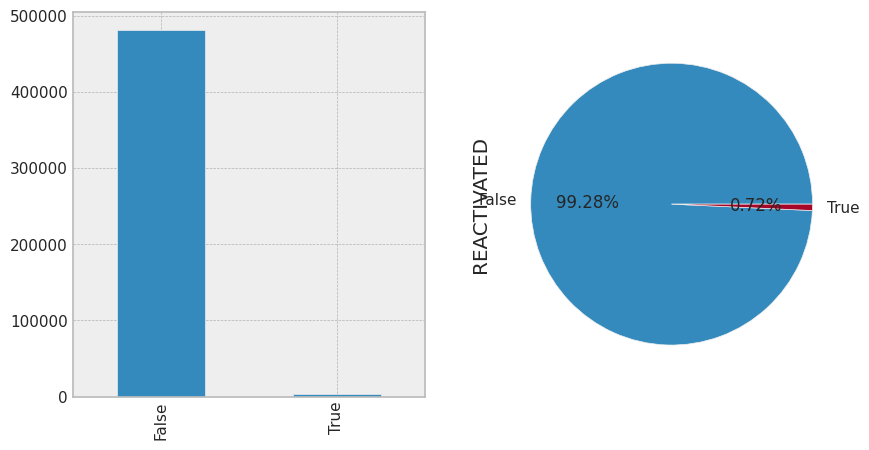

In [250]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
tmp['REACTIVATED'].value_counts().plot(kind='bar', ax=axes[0])
tmp['REACTIVATED'].value_counts().plot(kind='pie',autopct='%.2f%%', ax=axes[1])
plt.show()

In [251]:
# ti le REACTIVATE dc giu nguyen rat tot